# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [4]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [69]:
df.Class.mean()

0.001727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [4]:
df['hour'] = (df.Time / (60 * 60) % 24).astype(int)
df['day'] = (df.Time / (60 * 60) / 24).astype(int)
df.day.value_counts()

day
0    144786
1    140021
Name: count, dtype: int64

Всего 2 дня...

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

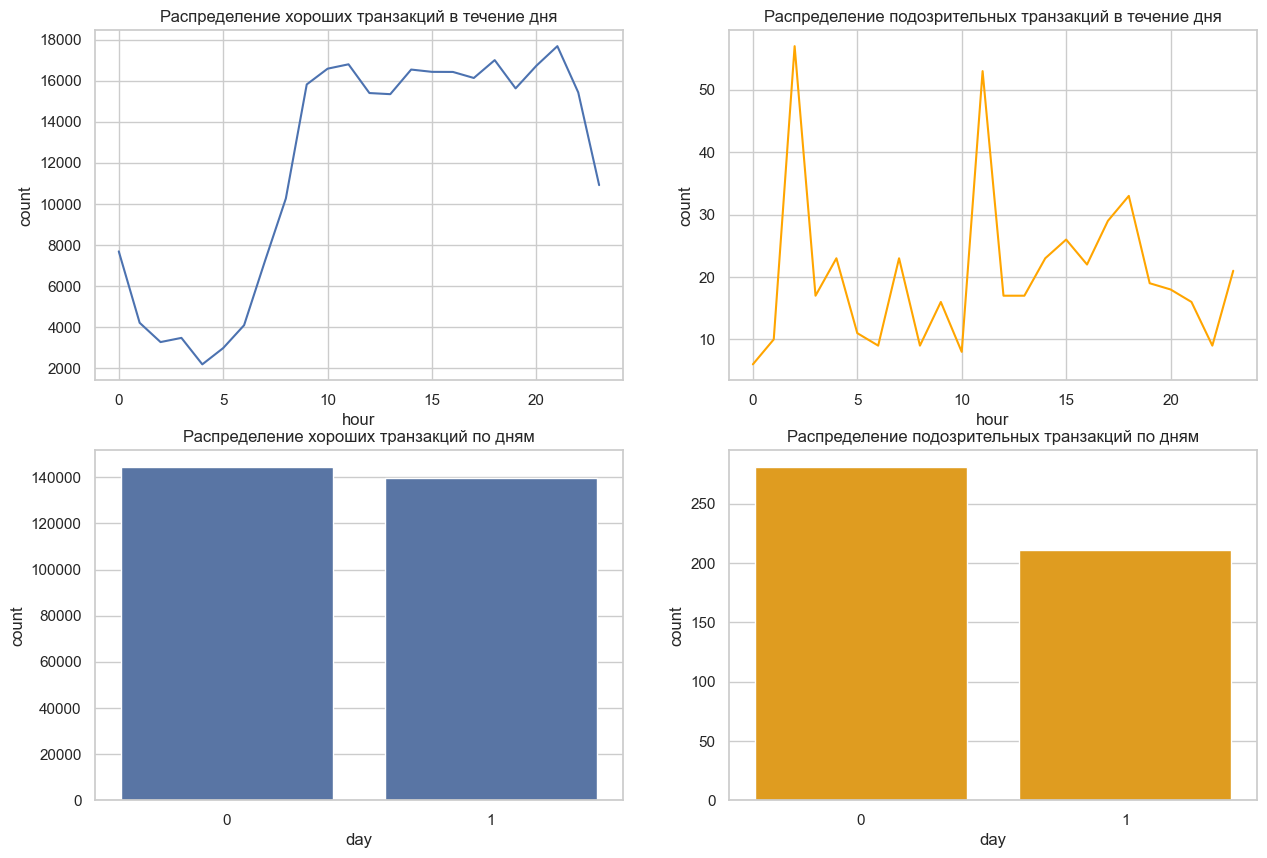

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

df_hours_count = df.groupby(['Class', 'hour'], sort=True)[['Class', 'hour']].agg(count=('Class', 'count')).reset_index()
df_days_count = df.groupby(['Class', 'day'], sort=True)[['Class', 'day']].agg(count=('Class', 'count')).reset_index()

sns.lineplot(df_hours_count[df_hours_count.Class == 0], x='hour', y='count', ax=ax[0][0])
ax[0][0].set_title('Распределение хороших транзакций в течение дня')

sns.lineplot(df_hours_count[df_hours_count.Class == 1], x='hour', y='count', color='orange', ax=ax[0][1])
ax[0][1].set_title('Распределение подозрительных транзакций в течение дня')

sns.barplot(df_days_count[df_days_count.Class == 0], x='day', y='count', ax=ax[1][0])
ax[1][0].set_title('Распределение хороших транзакций по дням')

sns.barplot(df_days_count[df_days_count.Class == 1], x='day', y='count', color='orange', ax=ax[1][1])
ax[1][1].set_title('Распределение подозрительных транзакций по дням')

plt.show()

1. По нашему графику хорошие транзакции начинают активно проводится в районе 9 часов утра, поэтому я бы сказал, что сдвиг всего в +1 час, потому что в реальности в 8 утра люди уже активно покупают кофе на работу, а в 9 вечера уже сидят дома. Возможно, я не прав, но существенного сдвига точно нет

2. Отсюда видно, что мошеннические транзакции имеют два пика: в районе 3 утра и 11 часов дня. Я могу только сказать, что выборка слишком маленькая, чтобы делать какие-то выводы, особенно с учетом того, что кейсы противоречивые: один пик в минимуме транзакций (что оооочень странно), другой - в начале дня (тут уже можно сказать, что они затесались в хорощие транзакции). С другой, стороны, кто сказал, что мошеннические транзакции проводятся в том же часовом поясе. Вывод: для предсказания в рамках двух дней пики окэй, но в общей ситуации это просто маленькая выборка для выводов.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

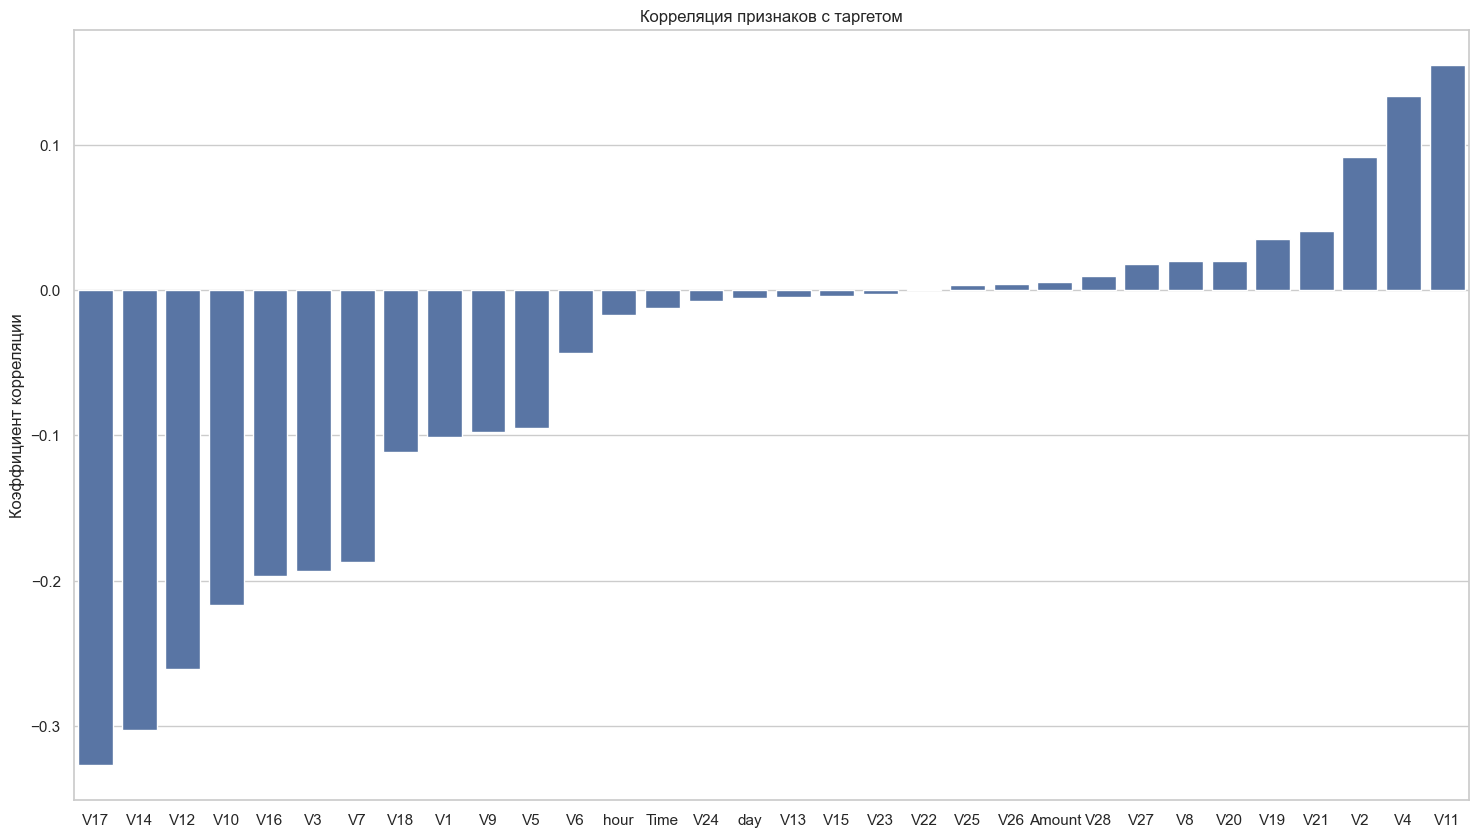

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

sns.barplot(df.drop(columns=['Class']).corrwith(df.Class).sort_values(), ax=ax)
ax.set_title('Корреляция признаков с таргетом')
ax.set_ylabel('Коэффициент корреляции')

# P.S.: с момента мо-1 я так и не понял, как в моей версии sns сделать цветные колонки без параметра hue, они как будто выпилили этот функционал

plt.show()

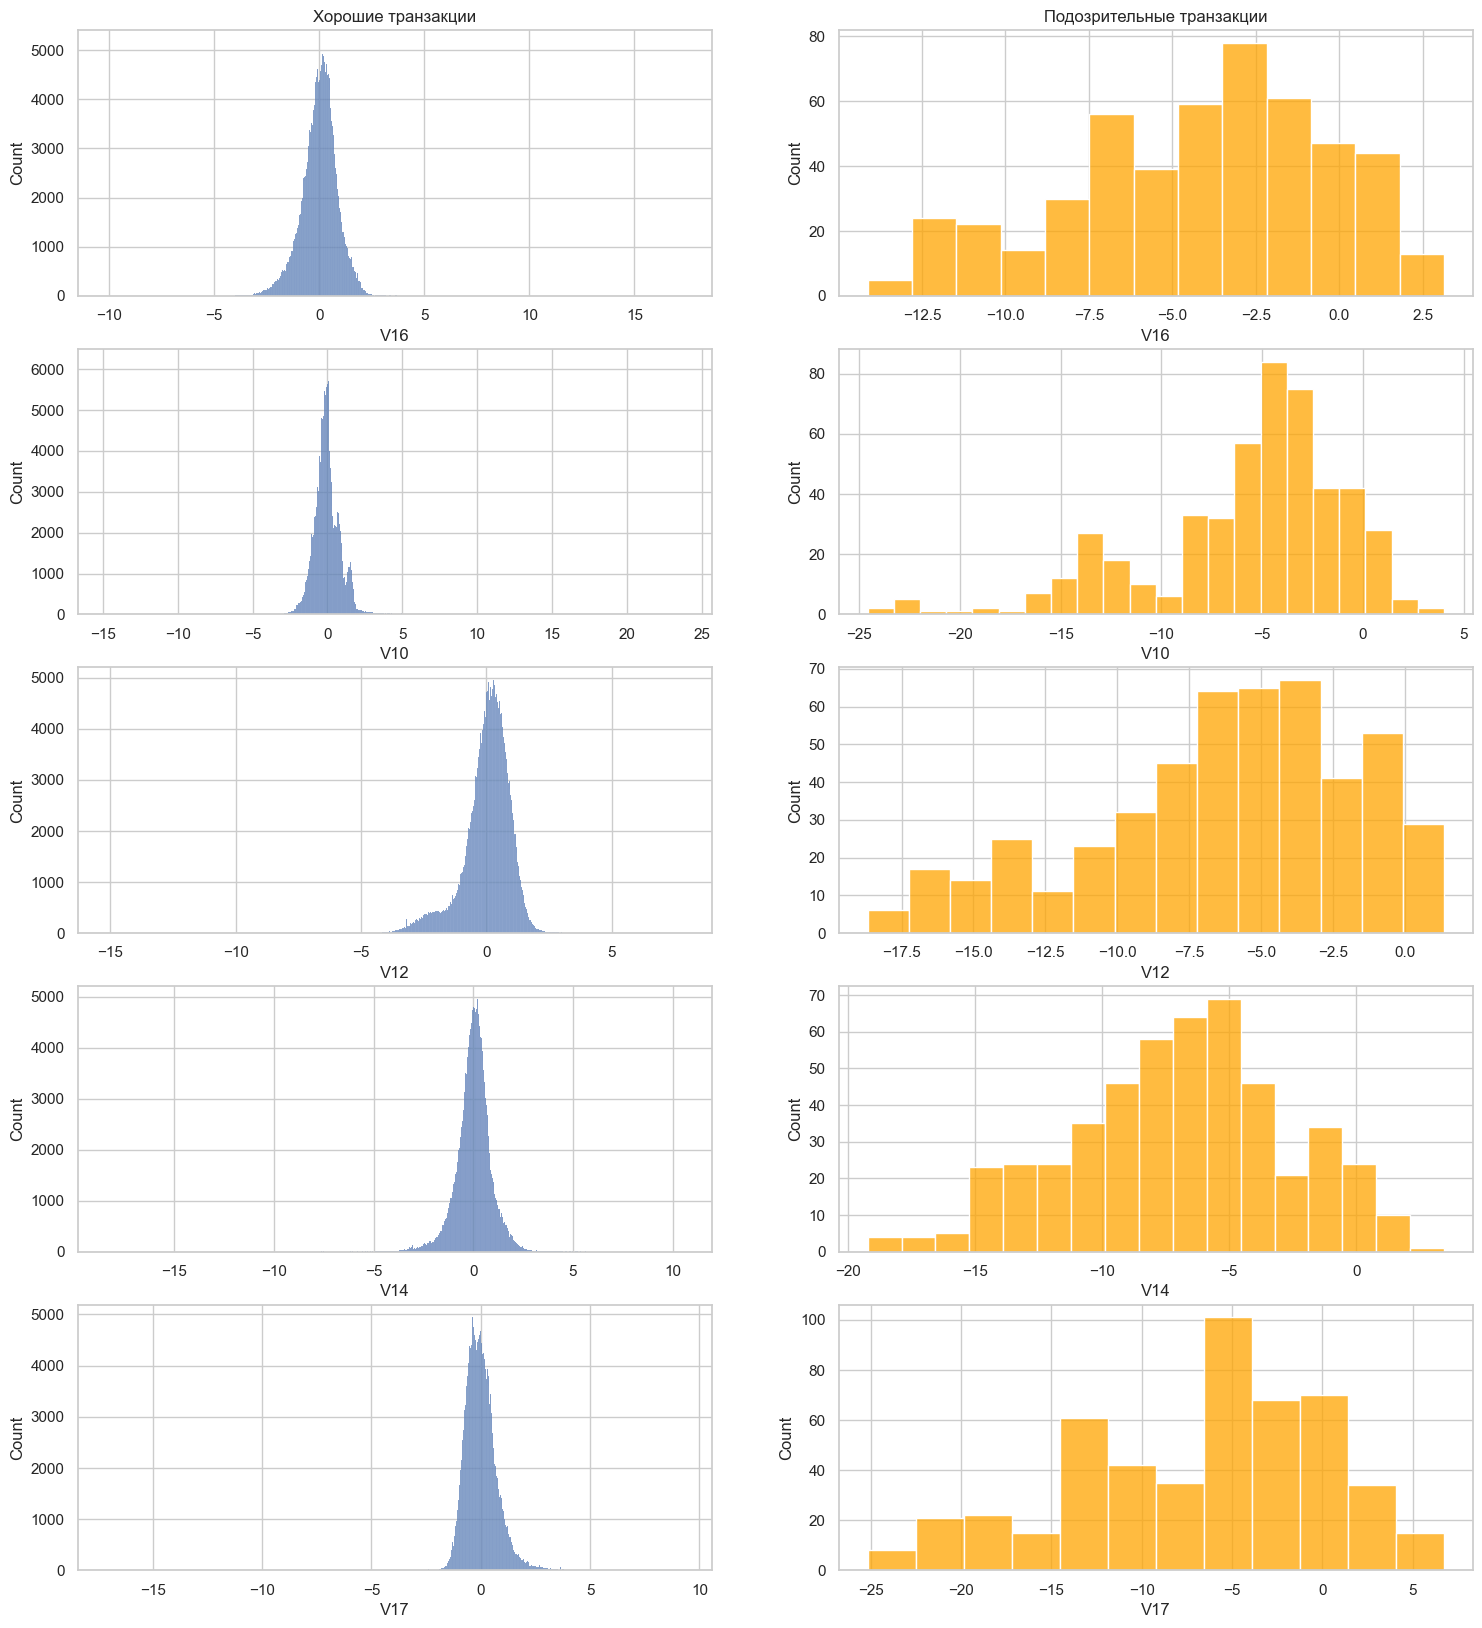

In [72]:
valuable_params = np.abs(df.drop(columns=['Class']).corrwith(df.Class)).sort_values().keys()[-5:]

fig, ax = plt.subplots(5, 2, figsize=(18, 20))

ax[0][0].set_title('Хорошие транзакции')
ax[0][1].set_title('Подозрительные транзакции')

for i, param in enumerate(valuable_params):
    sns.histplot(df[df.Class == 0], x=param, ax=ax[i][0])
    sns.histplot(df[df.Class == 1], x=param, ax=ax[i][1], color='orange')
    
plt.show()

Вот тут уже очень красиво видно, что признаки мошеннических операций находятся в зоне выбросов для хороших транзакций - возможно, тут достаточно эвристической модели :)))

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [5]:
from sklearn.model_selection import train_test_split

df_sorted = df.sort_values(by='Time')
df_train, df_test = train_test_split(df_sorted, test_size=0.2, shuffle=False)
df_val, df_test = train_test_split(df_test, test_size=0.5, shuffle=False)

X_train, y_train = df_train.drop(columns=['Class']), df_train.Class
X_val, y_val = df_val.drop(columns=['Class']), df_val.Class
X_test, y_test = df_test.drop(columns=['Class']), df_test.Class

df_train.Time.min(), df_train.Time.max(), df_val.Time.min(), df_val.Time.max(), df_test.Time.min(), df_test.Time.max()

(0.0, 145247.0, 145248.0, 157640.0, 157641.0, 172792.0)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [6]:
from sklearn.metrics import accuracy_score, auc, cohen_kappa_score, matthews_corrcoef, precision_recall_curve

def auc_pr(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)

def accuracy(y_true, y_proba, threshold=0.5):
    return accuracy_score(y_true, y_proba > threshold)

def cohen_kappa(y_true, y_proba, threshold=0.5):
    return cohen_kappa_score(y_true, y_proba > threshold)

def mcc(y_true, y_proba, threshold=0.5):
    return matthews_corrcoef(y_true, y_proba > threshold)

def calc_metrics(y_true, y_proba, threshold=0.5):
    return {
        'accuracy' : accuracy(y_true, y_proba, threshold),
        'auc_pr' : auc_pr(y_true, y_proba),
        'cohen_kappa' : cohen_kappa(y_true, y_proba, threshold),
        'mcc' : mcc(y_true, y_proba, threshold)
    }

In [7]:
print("Naive train metrics: ")
print(calc_metrics(y_train, np.zeros(y_train.shape)))

print("Naive val metrics: ")
print(calc_metrics(y_val, np.zeros(y_val.shape)))

print("Naive test metrics: ")
print(calc_metrics(y_test, np.zeros(y_test.shape)))

Naive train metrics: 
{'accuracy': 0.9981698084223924, 'auc_pr': 0.5009150957888038, 'cohen_kappa': 0.0, 'mcc': 0.0}
Naive val metrics: 
{'accuracy': 0.998139110284049, 'auc_pr': 0.5009304448579754, 'cohen_kappa': 0.0, 'mcc': 0.0}
Naive test metrics: 
{'accuracy': 0.9992275552122467, 'auc_pr': 0.5003862223938766, 'cohen_kappa': 0.0, 'mcc': 0.0}


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [7]:
from catboost import CatBoostClassifier
import optuna

In [28]:
def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 5, 95, step=10)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('tree_max_depth', 1, 15, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_train, y_train)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 00:23:50,963] A new study created in memory with name: no-name-e577e9a9-b0ca-4c0f-9669-0a99b91cfbde
[I 2024-05-20 00:23:54,961] Trial 0 finished with value: 0.7860934364515922 and parameters: {'n_estimators': 95, 'learning_rate': 2.543178748549091e-05, 'l2_leaf_reg': 27, 'tree_max_depth': 9}. Best is trial 0 with value: 0.7860934364515922.
[I 2024-05-20 00:23:56,186] Trial 1 finished with value: 0.7820791345554846 and parameters: {'n_estimators': 25, 'learning_rate': 0.0032030542564563886, 'l2_leaf_reg': 27, 'tree_max_depth': 9}. Best is trial 0 with value: 0.7860934364515922.
[I 2024-05-20 00:23:56,530] Trial 2 finished with value: 0.7570179145696291 and parameters: {'n_estimators': 15, 'learning_rate': 1.4882919087457983e-05, 'l2_leaf_reg': 17, 'tree_max_depth': 3}. Best is trial 0 with value: 0.7860934364515922.
[I 2024-05-20 00:24:04,817] Trial 3 finished with value: 0.8347604641437281 and parameters: {'n_estimators': 75, 'learning_rate': 0.048167484409286095, 'l2_lea

In [32]:
clf = CatBoostClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['tree_max_depth'],
    learning_rate=study.best_params['learning_rate'],
    l2_leaf_reg=study.best_params['l2_leaf_reg'],
    verbose=False
)
clf.fit(X_train, y_train)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9996137776061234,
 'auc_pr': 0.6498741303449104,
 'cohen_kappa': 0.7177586528421791,
 'mcc': 0.7237392722838328}

In [37]:
calc_metrics(y_test, y_test_proba, threshold=0.3)

{'accuracy': 0.9996488887328394,
 'auc_pr': 0.6498741303449104,
 'cohen_kappa': 0.7498260790128315,
 'mcc': 0.7536088618289372}

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

AUC_PR оказался ниже 0.7, но в остальном как надо

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

Далее не будем перебирать lr, потому что в прошлом экспе в топ запусках все вокруг дефолтного 3e-2

In [44]:
def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 5, 95, step=10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 15, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        verbose=False
    )

    classifier_obj.fit(X_train, y_train)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 01:12:01,974] A new study created in memory with name: no-name-05898db9-802d-4a72-9b63-6c30cfc6f98d
[I 2024-05-20 01:12:03,537] Trial 0 finished with value: 0.8468275963464248 and parameters: {'n_estimators': 25, 'l2_leaf_reg': 7, 'max_depth': 9}. Best is trial 0 with value: 0.8468275963464248.
[I 2024-05-20 01:12:05,462] Trial 1 finished with value: 0.7619144700324065 and parameters: {'n_estimators': 5, 'l2_leaf_reg': 29, 'max_depth': 13}. Best is trial 0 with value: 0.8468275963464248.
[I 2024-05-20 01:12:29,346] Trial 2 finished with value: 0.8474681081355723 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 27, 'max_depth': 13}. Best is trial 2 with value: 0.8474681081355723.
[I 2024-05-20 01:12:48,851] Trial 3 finished with value: 0.846771855488723 and parameters: {'n_estimators': 45, 'l2_leaf_reg': 1, 'max_depth': 13}. Best is trial 2 with value: 0.8474681081355723.
[I 2024-05-20 01:12:50,188] Trial 4 finished with value: 0.8293328147817033 and parameters: {'n_est

In [45]:
clf = CatBoostClassifier(**study.best_params, scale_pos_weight=len(y_train == 0) / len(y_train == 1), verbose=False)
clf.fit(X_train, y_train)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9995786664794073,
 'auc_pr': 0.6740776700701988,
 'cohen_kappa': 0.6840049779303127,
 'mcc': 0.6927057007478313}

Да вроде не сломалось. Возможно предполагалось взять модель из прошлого пункта и не перебирать остальные параметры, но это откровенно странно, потому что мы не просто меняем что-то в обучении, а буквально шатаем рельеф лосса.

In [46]:
(y_train == 0).sum() / (y_train == 1).sum()

545.3908872901678

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

**Вес [1; 101]**

In [48]:
def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 5, 95, step=10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)
    scale_pos_weight = trial.suggest_int("scale_pos_weight", 1, 101, step=5)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 15, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        scale_pos_weight=scale_pos_weight,
        verbose=False
    )

    classifier_obj.fit(X_train, y_train)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-05-20 01:29:01,369] A new study created in memory with name: no-name-47c92782-4f68-416f-9d0e-ff5498098d0d
[I 2024-05-20 01:29:02,756] Trial 0 finished with value: 0.8295546639384707 and parameters: {'n_estimators': 25, 'l2_leaf_reg': 21, 'scale_pos_weight': 11, 'max_depth': 9}. Best is trial 0 with value: 0.8295546639384707.
[I 2024-05-20 01:29:12,682] Trial 1 finished with value: 0.8398068214768053 and parameters: {'n_estimators': 85, 'l2_leaf_reg': 5, 'scale_pos_weight': 1, 'max_depth': 11}. Best is trial 1 with value: 0.8398068214768053.
[I 2024-05-20 01:29:14,415] Trial 2 finished with value: 0.849554920289586 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 15, 'scale_pos_weight': 36, 'max_depth': 9}. Best is trial 2 with value: 0.849554920289586.
[I 2024-05-20 01:29:15,663] Trial 3 finished with value: 0.8401699686434198 and parameters: {'n_estimators': 85, 'l2_leaf_reg': 23, 'scale_pos_weight': 16, 'max_depth': 3}. Best is trial 2 with value: 0.849554920289586.
[I 202

In [54]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_train, y_train)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9992977774656788,
 'auc_pr': 0.7157230544786821,
 'cohen_kappa': 0.6150415086382842,
 'mcc': 0.6224653822800065}

In [55]:
# Порог

clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_train, y_train)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

[I 2024-05-20 01:53:14,577] A new study created in memory with name: no-name-0c3081dd-3446-4918-84e2-f44b8aed2223
[I 2024-05-20 01:53:14,628] Trial 0 finished with value: 0.8522706913923024 and parameters: {'threshold': 0.55}. Best is trial 0 with value: 0.8522706913923024.
[I 2024-05-20 01:53:14,656] Trial 1 finished with value: 0.786427074025065 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 0.8522706913923024.
[I 2024-05-20 01:53:14,681] Trial 2 finished with value: 0.8522706913923024 and parameters: {'threshold': 0.55}. Best is trial 0 with value: 0.8522706913923024.
[I 2024-05-20 01:53:14,704] Trial 3 finished with value: 0.6972385484273238 and parameters: {'threshold': 0.25}. Best is trial 0 with value: 0.8522706913923024.
[I 2024-05-20 01:53:14,728] Trial 4 finished with value: 0.7116691107123775 and parameters: {'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.8522706913923024.
[I 2024-05-20 01:53:14,767] Trial 5 finished with value: 0.0 and par

In [56]:
y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

{'accuracy': 0.9994382219725431,
 'auc_pr': 0.7157230544786821,
 'cohen_kappa': 0.6663874946557107,
 'mcc': 0.6687173797351023}

Ну такое...

**Вес [0; 1]**

In [50]:
def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 5, 95, step=10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0, 1, step=0.1)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 15, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        scale_pos_weight=scale_pos_weight,
        verbose=False
    )

    classifier_obj.fit(X_train, y_train)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study_float = optuna.create_study(direction='maximize')
study_float.optimize(objective, n_trials=15)

[I 2024-05-20 01:37:47,164] A new study created in memory with name: no-name-8605567a-8071-46a4-a829-3152a6503674
[I 2024-05-20 01:39:22,683] Trial 0 finished with value: 0.8335962198366791 and parameters: {'n_estimators': 75, 'l2_leaf_reg': 21, 'scale_pos_weight': 0.9, 'max_depth': 15}. Best is trial 0 with value: 0.8335962198366791.
[I 2024-05-20 01:41:20,879] Trial 1 finished with value: 0.8042934391983874 and parameters: {'n_estimators': 75, 'l2_leaf_reg': 13, 'scale_pos_weight': 0.30000000000000004, 'max_depth': 15}. Best is trial 0 with value: 0.8335962198366791.
[I 2024-05-20 01:41:30,071] Trial 2 finished with value: 0.8509387687248262 and parameters: {'n_estimators': 65, 'l2_leaf_reg': 1, 'scale_pos_weight': 0.8, 'max_depth': 11}. Best is trial 2 with value: 0.8509387687248262.
[I 2024-05-20 01:41:33,339] Trial 3 finished with value: 0.7803222839686975 and parameters: {'n_estimators': 25, 'l2_leaf_reg': 19, 'scale_pos_weight': 0.30000000000000004, 'max_depth': 11}. Best is tri

In [51]:
clf = CatBoostClassifier(**study_float.best_params, verbose=False)
clf.fit(X_train, y_train)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9997191109862715,
 'auc_pr': 0.7246685126707789,
 'cohen_kappa': 0.7776441885429881,
 'mcc': 0.7976119362834546}

Wow!

In [65]:
# Порог

clf = CatBoostClassifier(**study_float.best_params, verbose=False)
clf.fit(X_train, y_train)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

[I 2024-05-20 02:01:01,804] A new study created in memory with name: no-name-3dcccadc-1be6-4f9b-a38e-7e0352203be1
[I 2024-05-20 02:01:01,891] Trial 0 finished with value: 0.800675317593141 and parameters: {'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.800675317593141.
[I 2024-05-20 02:01:01,927] Trial 1 finished with value: 0.8146033787180956 and parameters: {'threshold': 0.05}. Best is trial 1 with value: 0.8146033787180956.
[I 2024-05-20 02:01:01,952] Trial 2 finished with value: 0.8467917871368241 and parameters: {'threshold': 0.2}. Best is trial 2 with value: 0.8467917871368241.
[I 2024-05-20 02:01:01,980] Trial 3 finished with value: 0.62911120162991 and parameters: {'threshold': 0.9}. Best is trial 2 with value: 0.8467917871368241.
[I 2024-05-20 02:01:02,024] Trial 4 finished with value: 0.8123789056196511 and parameters: {'threshold': 0.6000000000000001}. Best is trial 2 with value: 0.8467917871368241.
[I 2024-05-20 02:01:02,052] Trial 5 finished with value: 0.

In [67]:
y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

{'accuracy': 0.9996839998595555,
 'auc_pr': 0.7246685126707789,
 'cohen_kappa': 0.7690752614163283,
 'mcc': 0.7754834690252622}

In [68]:
study_float.best_params, study_threshold.best_params

({'n_estimators': 65,
  'l2_leaf_reg': 1,
  'scale_pos_weight': 0.8,
  'max_depth': 11},
 {'threshold': 0.30000000000000004})

**Вес [700; 1500]**

In [52]:
def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 5, 95, step=10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)
    scale_pos_weight = trial.suggest_int("scale_pos_weight", 700, 1500, step=100)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 15, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        scale_pos_weight=scale_pos_weight,
        verbose=False
    )

    classifier_obj.fit(X_train, y_train)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study_extreme = optuna.create_study(direction='maximize')
study_extreme.optimize(objective, n_trials=15)

[I 2024-05-20 01:45:30,221] A new study created in memory with name: no-name-ebd323b5-f18d-4b17-b74d-2b6500c976e4
[I 2024-05-20 01:45:31,638] Trial 0 finished with value: 0.8219127620837984 and parameters: {'n_estimators': 75, 'l2_leaf_reg': 29, 'scale_pos_weight': 1000, 'max_depth': 5}. Best is trial 0 with value: 0.8219127620837984.
[I 2024-05-20 01:45:31,901] Trial 1 finished with value: 0.7936659539996558 and parameters: {'n_estimators': 5, 'l2_leaf_reg': 19, 'scale_pos_weight': 1400, 'max_depth': 5}. Best is trial 0 with value: 0.8219127620837984.
[I 2024-05-20 01:45:33,047] Trial 2 finished with value: 0.8274834835427868 and parameters: {'n_estimators': 75, 'l2_leaf_reg': 13, 'scale_pos_weight': 900, 'max_depth': 3}. Best is trial 2 with value: 0.8274834835427868.
[I 2024-05-20 01:45:44,820] Trial 3 finished with value: 0.8515882235751479 and parameters: {'n_estimators': 95, 'l2_leaf_reg': 3, 'scale_pos_weight': 1400, 'max_depth': 11}. Best is trial 3 with value: 0.85158822357514

In [53]:
clf = CatBoostClassifier(**study_extreme.best_params, verbose=False)
clf.fit(X_train, y_train)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9983146659176293,
 'auc_pr': 0.7045324964203439,
 'cohen_kappa': 0.3993272194902475,
 'mcc': 0.4472880802075219}

Extremely bad

In [63]:
# Порог

clf = CatBoostClassifier(**study_extreme.best_params, verbose=False)
clf.fit(X_train, y_train)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

[I 2024-05-20 02:00:08,029] A new study created in memory with name: no-name-1855e369-4bf3-42be-baa1-1f28740e7f89
[I 2024-05-20 02:00:08,105] Trial 0 finished with value: 0.5463662480035831 and parameters: {'threshold': 0.35000000000000003}. Best is trial 0 with value: 0.5463662480035831.
[I 2024-05-20 02:00:08,142] Trial 1 finished with value: 0.5883317277689181 and parameters: {'threshold': 0.4}. Best is trial 1 with value: 0.5883317277689181.
[I 2024-05-20 02:00:08,181] Trial 2 finished with value: 0.800675317593141 and parameters: {'threshold': 0.9500000000000001}. Best is trial 2 with value: 0.800675317593141.
[I 2024-05-20 02:00:08,221] Trial 3 finished with value: 0.4894517991398193 and parameters: {'threshold': 0.30000000000000004}. Best is trial 2 with value: 0.800675317593141.
[I 2024-05-20 02:00:08,266] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.0}. Best is trial 2 with value: 0.800675317593141.
[I 2024-05-20 02:00:08,309] Trial 5 finished with value: 0

In [64]:
y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

{'accuracy': 0.999403110845827,
 'auc_pr': 0.7045324964203439,
 'cohen_kappa': 0.6527656357910786,
 'mcc': 0.6561966972262978}

**Итог:** на мое удивление, наилучшим оказался вес позитивного класса **0.8**, который с порогом 0.5 (да-да, перебор на валидации дал другой лучший, но будем считать, что мы заслали в контест сначала 0.5) дал очень высокие метрики.

**Accuracy** 99.97% \
**AUC-PR** 0.725 \
**Cohen-Kappa** 0.778 \
**MCC** 0.798

**P.S.:** я так и не смог понять, почему вес < 1 работает лучше. Вроде бага нигде нет, вес применяется к минорному классу 1, вклад ошибок на минорном классе в лосс уменьшается, выучиваться они должны хуже. Я даже нашел место в исходном коде катбуста, где идет применение весов ([тут](https://github.com/catboost/catboost/blob/3b9d643d6c7242db21a8c1be23573a8b9e432519/contrib/python/scikit-learn/py2/sklearn/linear_model/logistic.py#L116)), да и формируется он вроде тоже правильно [тут](https://github.com/catboost/catboost/blob/3b9d643d6c7242db21a8c1be23573a8b9e432519/catboost/python-package/catboost/core.py#L1584). Вероятно, дело в том, что перебор мы делаем на auc-pr.

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [70]:
!pip3 install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 1.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [8]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

**1:1**

In [11]:
# В первый раз этот перебор убил мой потрепанный курсом глубинного обучения и курсачом интеловский мак, поэтому я урезал параметры перебора на основе экспериментов выше
# Зато про модели из бонуса успел почитать...

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 04:37:49,008] A new study created in memory with name: no-name-d3612b7e-f73d-47aa-9e2e-306693de8ece
[I 2024-05-20 04:37:50,945] Trial 0 finished with value: 0.7887047945286415 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 9, 'max_depth': 4}. Best is trial 0 with value: 0.7887047945286415.
[I 2024-05-20 04:37:52,310] Trial 1 finished with value: 0.7870387961652223 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 27, 'max_depth': 4}. Best is trial 0 with value: 0.7887047945286415.
[I 2024-05-20 04:37:54,525] Trial 2 finished with value: 0.8116038396780315 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 3, 'max_depth': 6}. Best is trial 2 with value: 0.8116038396780315.
[I 2024-05-20 04:37:57,472] Trial 3 finished with value: 0.8209081646642522 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 25, 'max_depth': 8}. Best is trial 3 with value: 0.8209081646642522.
[I 2024-05-20 04:37:58,981] Trial 4 finished with value: 0.7937448397074751 and parameters: {'n_esti

In [12]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9980337769039008,
 'auc_pr': 0.7262792344399133,
 'cohen_kappa': 0.3770506401989143,
 'mcc': 0.4388600452532341}

In [13]:
# Порог

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 04:40:05,395] A new study created in memory with name: no-name-ae211ba4-5368-402a-9ecd-628d4859f60d
[I 2024-05-20 04:40:05,432] Trial 0 finished with value: 0.6596211968274207 and parameters: {'threshold': 0.6000000000000001}. Best is trial 0 with value: 0.6596211968274207.
[I 2024-05-20 04:40:05,483] Trial 1 finished with value: 0.46945162140403757 and parameters: {'threshold': 0.35000000000000003}. Best is trial 0 with value: 0.6596211968274207.
[I 2024-05-20 04:40:05,517] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.0}. Best is trial 0 with value: 0.6596211968274207.
[I 2024-05-20 04:40:05,547] Trial 3 finished with value: 0.7003438650194492 and parameters: {'threshold': 0.65}. Best is trial 3 with value: 0.7003438650194492.
[I 2024-05-20 04:40:05,575] Trial 4 finished with value: 0.7264815261467494 and parameters: {'threshold': 0.7000000000000001}. Best is trial 4 with value: 0.7264815261467494.
[I 2024-05-20 04:40:05,603] Trial 5 finished with val

{'accuracy': 0.9997542221129876,
 'auc_pr': 0.7262792344399133,
 'cohen_kappa': 0.8203918699904775,
 'mcc': 0.8272276657666917}

Ого!

**1:2**

In [17]:
X_resampled, y_resampled = SMOTE(sampling_strategy=0.5).fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 04:42:26,228] A new study created in memory with name: no-name-499a7186-9af4-4ef4-987a-ab82d8bbc0c2
[I 2024-05-20 04:42:29,075] Trial 0 finished with value: 0.8383908574534097 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 7, 'max_depth': 10}. Best is trial 0 with value: 0.8383908574534097.
[I 2024-05-20 04:42:30,077] Trial 1 finished with value: 0.8310587203331831 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 3, 'max_depth': 6}. Best is trial 0 with value: 0.8383908574534097.
[I 2024-05-20 04:42:38,734] Trial 2 finished with value: 0.8448375377483002 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 13, 'max_depth': 12}. Best is trial 2 with value: 0.8448375377483002.
[I 2024-05-20 04:42:40,186] Trial 3 finished with value: 0.8295482854416989 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 11, 'max_depth': 8}. Best is trial 2 with value: 0.8448375377483002.
[I 2024-05-20 04:42:41,773] Trial 4 finished with value: 0.8244031731822817 and parameters: {'n_es

In [18]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9982444436641972,
 'auc_pr': 0.7178907544232761,
 'cohen_kappa': 0.38955384983380503,
 'mcc': 0.4397429882029264}

In [19]:
# Порог

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 04:44:37,854] A new study created in memory with name: no-name-5be68172-9793-486d-a92b-8b75eed7059d
[I 2024-05-20 04:44:37,886] Trial 0 finished with value: 0.5695487837074801 and parameters: {'threshold': 0.4}. Best is trial 0 with value: 0.5695487837074801.
[I 2024-05-20 04:44:37,917] Trial 1 finished with value: 0.8392658757212702 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 0.8392658757212702.
[I 2024-05-20 04:44:37,948] Trial 2 finished with value: 0.7888865791460244 and parameters: {'threshold': 0.75}. Best is trial 1 with value: 0.8392658757212702.
[I 2024-05-20 04:44:37,980] Trial 3 finished with value: 0.18932255406701493 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 0.8392658757212702.
[I 2024-05-20 04:44:38,011] Trial 4 finished with value: 0.43207914880700543 and parameters: {'threshold': 0.25}. Best is trial 1 with value: 0.8392658757212702.
[I 2024-05-20 04:44:38,040] Trial 5 finished with value: 0.679290194311292 and par

{'accuracy': 0.9996488887328394,
 'auc_pr': 0.7178907544232761,
 'cohen_kappa': 0.7617294754049536,
 'mcc': 0.7625958622585118}

**1:10**

In [20]:
X_resampled, y_resampled = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 04:45:38,294] A new study created in memory with name: no-name-da2ebb84-c1db-4bd4-b179-891dca04b65a
[I 2024-05-20 04:45:46,855] Trial 0 finished with value: 0.8592840639826831 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 11, 'max_depth': 12}. Best is trial 0 with value: 0.8592840639826831.
[I 2024-05-20 04:45:48,600] Trial 1 finished with value: 0.8514213792411167 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 15, 'max_depth': 6}. Best is trial 0 with value: 0.8592840639826831.
[I 2024-05-20 04:45:52,445] Trial 2 finished with value: 0.8567005416393145 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 29, 'max_depth': 10}. Best is trial 0 with value: 0.8592840639826831.
[I 2024-05-20 04:45:53,290] Trial 3 finished with value: 0.8572661611932955 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 25, 'max_depth': 6}. Best is trial 0 with value: 0.8592840639826831.
[I 2024-05-20 04:45:54,437] Trial 4 finished with value: 0.8487126536886361 and parameters: {'n_

In [21]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9989466661985184,
 'auc_pr': 0.7173528767114358,
 'cohen_kappa': 0.5156462754710436,
 'mcc': 0.5389049208949829}

In [22]:
# Порог

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 04:47:07,600] A new study created in memory with name: no-name-5c974b81-5645-4d42-bbfb-e693ffb5e9b3
[I 2024-05-20 04:47:07,631] Trial 0 finished with value: 0.46350045825825165 and parameters: {'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.46350045825825165.
[I 2024-05-20 04:47:07,661] Trial 1 finished with value: 0.706760312224892 and parameters: {'threshold': 0.4}. Best is trial 1 with value: 0.706760312224892.
[I 2024-05-20 04:47:07,692] Trial 2 finished with value: 0.0 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 0.706760312224892.
[I 2024-05-20 04:47:07,722] Trial 3 finished with value: 0.8352966615113866 and parameters: {'threshold': 0.9}. Best is trial 3 with value: 0.8352966615113866.
[I 2024-05-20 04:47:07,751] Trial 4 finished with value: 0.822131792470955 and parameters: {'threshold': 0.55}. Best is trial 3 with value: 0.8352966615113866.
[I 2024-05-20 04:47:07,778] Trial 5 finished with value: 0.5335574379325096 and parame

{'accuracy': 0.9997542221129876,
 'auc_pr': 0.7173528767114358,
 'cohen_kappa': 0.8203918699904775,
 'mcc': 0.8272276657666917}

**Итого:** этот подход оказался еще лучше, чем изменение веса. Это можно объяснить тем, что мы не просто стараемся уйти от проблемы несбалансированности, но еще и делаем своего рода аугментацию. Лучшие параметры были с соотношением 1:1 (хотя с 1:10 было очень близко):

**Accuracy** 0.9998 \
**AUC-PR** 0.726 \
**Cohen-Kappa** 0.820 \
**MCC** 0.827

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - хотим строить точки чуть более умно, а именно сэмплить их ближе к границам минорного класса. Для этого сначала из имеющихся объектов выбираются предполагаемые границы (рассматриваются $m$ ближайших соседей и проверяется, что для граничного доля элементов мажорного класса среди этих $m$ больше $p$). Далее строится SMOTE на основе граничных точек. Подобная аугментация лучше формирует зоны точек минорного класса.

SVM-SMOTE - тут цель примерно такая же: построить точки, близкие к границе. Для этого сначала обучается SVM, а затем SMOTE строится на самых близких к границе (опорным векторам) точках минорного класса. Идея та же - помогает растить разделимость точек.

K-Means-SMOTE - здесь цель уже не в добавлении объектов на границы, а в устранении разрезженности областей минорного класса. Сначала всё пространство кластеризуется при помощи K-Means (и минорный, и мажорный классы вместе), а затем выбираются только кластеры, где превалируют объекты минорного класса. В выбранных кластерах запускается SMOTE, при этом количество сэмплов зависит от разрезженности кластера - чем более разрезженный, тем больше сэмплов. Этот подход позволяет не сэмплить лишний шум и создавать плотные области минорного класса.

ADASYN - в отличие от предыдущих методов не выбирает отдельно подмножество минорного класса для построения новых точек. Вместо этого среди K ближайших соседей точки минорного класса считает долю объектов мажорного класса. Теперь для каждой минорной точки строит количество новых объектов пропорционально полученной доли минорных - чем больше вокруг минорных, тем больше надо насэмплировать точек вокруг. Для построения использует ту же процедуру, что и SMOTE, выбирая минорную точку из ранее построенных соседей. Алгоритм дополнительно выделяет "затерявшиеся точки".

Теперь попробуйте сравнить качество всех методов на наших данных.

**BorderlineSMOTE**

In [23]:
from imblearn.over_sampling import BorderlineSMOTE

X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 05:26:21,595] A new study created in memory with name: no-name-634a60d4-3973-4a9e-97c7-5022b1461c3e
[I 2024-05-20 05:26:31,443] Trial 0 finished with value: 0.8390939074808078 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 29, 'max_depth': 12}. Best is trial 0 with value: 0.8390939074808078.
[I 2024-05-20 05:26:34,054] Trial 1 finished with value: 0.8478738549831946 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 19, 'max_depth': 8}. Best is trial 1 with value: 0.8478738549831946.
[I 2024-05-20 05:26:35,592] Trial 2 finished with value: 0.8431774270299782 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 1, 'max_depth': 4}. Best is trial 1 with value: 0.8478738549831946.
[I 2024-05-20 05:26:38,285] Trial 3 finished with value: 0.8458731818814965 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 11, 'max_depth': 8}. Best is trial 1 with value: 0.8478738549831946.
[I 2024-05-20 05:26:46,356] Trial 4 finished with value: 0.8472269548753352 and parameters: {'n_es

In [24]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 05:28:33,887] A new study created in memory with name: no-name-6a290a7e-0d80-4778-8b68-1a61f5f79510
[I 2024-05-20 05:28:33,918] Trial 0 finished with value: 0.8267600671097609 and parameters: {'threshold': 0.4}. Best is trial 0 with value: 0.8267600671097609.
[I 2024-05-20 05:28:33,946] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.0}. Best is trial 0 with value: 0.8267600671097609.
[I 2024-05-20 05:28:33,973] Trial 2 finished with value: 0.8187507473801507 and parameters: {'threshold': 0.35000000000000003}. Best is trial 0 with value: 0.8267600671097609.
[I 2024-05-20 05:28:34,002] Trial 3 finished with value: 0.31902528782583456 and parameters: {'threshold': 0.05}. Best is trial 0 with value: 0.8267600671097609.
[I 2024-05-20 05:28:34,029] Trial 4 finished with value: 0.5938109344683193 and parameters: {'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.8267600671097609.
[I 2024-05-20 05:28:34,061] Trial 5 finished with value: 0.82676006

{'accuracy': 0.9996137776061234,
 'auc_pr': 0.683267816044286,
 'cohen_kappa': 0.7439928940257028,
 'mcc': 0.7441944677557768}

**SVM-SMOTE**

In [25]:
from imblearn.over_sampling import SVMSMOTE

X_resampled, y_resampled = SVMSMOTE().fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 05:29:50,536] A new study created in memory with name: no-name-4d37eecf-1c83-4229-a7c6-f61685c5209e
[I 2024-05-20 05:29:58,809] Trial 0 finished with value: 0.8446540805111553 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 23, 'max_depth': 12}. Best is trial 0 with value: 0.8446540805111553.
[I 2024-05-20 05:30:09,116] Trial 1 finished with value: 0.8382958777998532 and parameters: {'n_estimators': 45, 'l2_leaf_reg': 11, 'max_depth': 12}. Best is trial 0 with value: 0.8446540805111553.
[I 2024-05-20 05:30:19,906] Trial 2 finished with value: 0.842246874953837 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 3, 'max_depth': 12}. Best is trial 0 with value: 0.8446540805111553.
[I 2024-05-20 05:30:30,834] Trial 3 finished with value: 0.8378695800327981 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 27, 'max_depth': 12}. Best is trial 0 with value: 0.8446540805111553.
[I 2024-05-20 05:30:32,814] Trial 4 finished with value: 0.8474873212277488 and parameters: {'n_

In [26]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 05:32:25,780] A new study created in memory with name: no-name-25a5cb0e-0e4a-4bb7-8d8d-d0d560214563
[I 2024-05-20 05:32:25,827] Trial 0 finished with value: 0.846524079607583 and parameters: {'threshold': 0.65}. Best is trial 0 with value: 0.846524079607583.
[I 2024-05-20 05:32:25,865] Trial 1 finished with value: 0.8576052995224998 and parameters: {'threshold': 0.55}. Best is trial 1 with value: 0.8576052995224998.
[I 2024-05-20 05:32:25,903] Trial 2 finished with value: 0.846524079607583 and parameters: {'threshold': 0.75}. Best is trial 1 with value: 0.8576052995224998.
[I 2024-05-20 05:32:25,937] Trial 3 finished with value: 0.8578636046566044 and parameters: {'threshold': 0.5}. Best is trial 3 with value: 0.8578636046566044.
[I 2024-05-20 05:32:25,975] Trial 4 finished with value: 0.8475648123459499 and parameters: {'threshold': 0.4}. Best is trial 3 with value: 0.8578636046566044.
[I 2024-05-20 05:32:26,010] Trial 5 finished with value: 0.8576052995224998 and parame

{'accuracy': 0.9995084442259752,
 'auc_pr': 0.696475283529648,
 'cohen_kappa': 0.6954066627453077,
 'mcc': 0.6960659441542087}

**K-Means SMOTE**

In [31]:
from imblearn.over_sampling import KMeansSMOTE

X_resampled, y_resampled = KMeansSMOTE(cluster_balance_threshold=1e-4).fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
[I 2024-05-20 05:36:40,322] A new study created in memory with name: no-name-5051723f-e010-43ae-9153-63f2b0fbdf7b
[I 2024-05-20 05:36:41,649] Trial 0 finished with value: 0.7978847022934382 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 29, 'max_depth': 4}. Best is trial 0 with value: 0.7978847022934382.
[I 2024-05-20 05:36:43,726] Trial 1 finished with value: 0.8435619775835873 and parameters: {'n_estimators': 50, 'l2_leaf_reg': 5, 'max_depth': 6}. Best is trial 1 with value: 0.8435619775835873.
[I 2024-05-20 05:36:45,818] Trial 2 finished with value: 0.8164758776212182 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 15, 'max_depth': 4}. Best is trial 1 with value: 0.8435619775835873.
[I 2024-05-20 05:36:48,874

In [32]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 05:38:48,704] A new study created in memory with name: no-name-6e1bf694-3b5b-49a6-b0bc-be2b4d06f2ed
[I 2024-05-20 05:38:48,730] Trial 0 finished with value: 0.8392658757212702 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 0.8392658757212702.
[I 2024-05-20 05:38:48,754] Trial 1 finished with value: 0.846524079607583 and parameters: {'threshold': 0.45}. Best is trial 1 with value: 0.846524079607583.
[I 2024-05-20 05:38:48,780] Trial 2 finished with value: 0.8239170684958809 and parameters: {'threshold': 0.65}. Best is trial 1 with value: 0.846524079607583.
[I 2024-05-20 05:38:48,815] Trial 3 finished with value: 0.0 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 0.846524079607583.
[I 2024-05-20 05:38:48,849] Trial 4 finished with value: 0.7393972270655225 and parameters: {'threshold': 0.8500000000000001}. Best is trial 1 with value: 0.846524079607583.
[I 2024-05-20 05:38:48,880] Trial 5 finished with value: 0.8352966615113866 and parameter

{'accuracy': 0.9996488887328394,
 'auc_pr': 0.6920202050261118,
 'cohen_kappa': 0.7617294754049536,
 'mcc': 0.7625958622585118}

**ADASYN**

In [33]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

def objective(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 05:39:05,918] A new study created in memory with name: no-name-4368df5a-e397-40ee-b9b1-e71693874bb6
[I 2024-05-20 05:39:07,224] Trial 0 finished with value: 0.7842238168177782 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 7, 'max_depth': 4}. Best is trial 0 with value: 0.7842238168177782.
[I 2024-05-20 05:39:08,553] Trial 1 finished with value: 0.7989832094541626 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 27, 'max_depth': 6}. Best is trial 1 with value: 0.7989832094541626.
[I 2024-05-20 05:39:10,156] Trial 2 finished with value: 0.7908864093705913 and parameters: {'n_estimators': 50, 'l2_leaf_reg': 13, 'max_depth': 4}. Best is trial 1 with value: 0.7989832094541626.
[I 2024-05-20 05:39:12,893] Trial 3 finished with value: 0.8275928261142709 and parameters: {'n_estimators': 50, 'l2_leaf_reg': 17, 'max_depth': 8}. Best is trial 3 with value: 0.8275928261142709.
[I 2024-05-20 05:39:17,884] Trial 4 finished with value: 0.8145148158445344 and parameters: {'n_est

In [34]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 05:41:13,140] A new study created in memory with name: no-name-f0f54b0c-3f1a-41eb-8c83-ffee0bc4f34d
[I 2024-05-20 05:41:13,166] Trial 0 finished with value: 0.850358109092135 and parameters: {'threshold': 0.8500000000000001}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-20 05:41:13,195] Trial 1 finished with value: 0.40388724628199113 and parameters: {'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-20 05:41:13,226] Trial 2 finished with value: 0.24577408539281723 and parameters: {'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-20 05:41:13,260] Trial 3 finished with value: 0.815547361157855 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-20 05:41:13,296] Trial 4 finished with value: 0.1702617132387166 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-20 05:41:13,326] Trial 5 finished

{'accuracy': 0.9995435553526912,
 'auc_pr': 0.7134652517175608,
 'cohen_kappa': 0.7108828212298137,
 'mcc': 0.7110586906187203}

**Итог:** к сожалению, с дефолтными (почти) гиперпараметрами только ADASYN смог получить auc-pr выше 0.7, однако по Cohen-Kappa и MCC значительно уступил K-Means SMOTE. При этом классический SMOTE никто не побил. Скорее всего, нужно больше исследований датасета (порисовать PCA, например) и перебор гиперпараметров.

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [40]:
from imblearn.under_sampling import RandomUnderSampler

In [61]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

params_df = pd.DataFrame(columns=["ratio", "accuracy", "auc_pr", "cohen_kappa", "mcc",
                                  "threshold", "n_estimators", "l2_leaf_reg", "max_depth"])

# Перебираем от 1:10 до 1:1
for ratio in tqdm(np.arange(0.1, 1.1, 0.1)):

    X_resampled, y_resampled = RandomUnderSampler(sampling_strategy=ratio).fit_resample(X_train, y_train)
    squeeze_rate = (y_train == 0).sum() / (y_resampled == 0).sum()
    
    def objective_catboost(trial): 
        # Boosting hyperparameters
        n_estimators =  trial.suggest_int('n_estimators', 30, 60, step=5)
        l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

        # DecisionTree hyperparameters
        max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

        classifier_obj = CatBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            l2_leaf_reg=l2_leaf_reg,
            verbose=False
        )

        classifier_obj.fit(X_resampled, y_resampled)
        y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba)
        return metrics['auc_pr']

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_catboost, n_trials=12)

    # Да простит меня ассистент за постоянную копипасту поиска оптимального порога
    clf = CatBoostClassifier(**study.best_params, verbose=False)
    clf.fit(X_resampled, y_resampled)

    def objective_threshold(trial): 
        threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
        return metrics['mcc']

    study_threshold = optuna.create_study(direction='maximize')
    study_threshold.optimize(objective_threshold, n_trials=20)

    y_test_proba = clf.predict_proba(X_test)[:, 1]
    final_metrcis = calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

    params = {"ratio" : ratio, "squeeze_rate": squeeze_rate} | final_metrcis | study_threshold.best_params | study.best_params
    params = pd.DataFrame.from_dict(params, orient='index').T
    params_df = pd.concat((params_df, params), ignore_index=True)

params_df

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/pb/b204xgmn6mq45r8smpqfg__8sdc80l/T/ipykernel_1144/2200389973.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_df = pd.concat((params_df, params), ignore_index=True)


,ratio,accuracy,auc_pr,cohen_kappa,mcc,threshold,n_estimators,l2_leaf_reg,max_depth,squeeze_rate
0,0.1,0.999403,0.663429,0.638000,0.639306,0.75,50.0,1.0,8.0,54.539089
1,0.2,0.999579,0.670818,0.714075,0.714888,0.80,30.0,1.0,4.0,109.078177
2,0.3,0.999544,0.707343,0.710883,0.711059,0.70,45.0,13.0,10.0,163.735061
3,0.4,0.999579,0.705163,0.727062,0.727062,0.80,55.0,11.0,6.0,218.261036
4,0.5,0.999544,0.711623,0.710883,0.711059,0.75,45.0,3.0,10.0,272.695444
5,0.6,0.999544,0.723654,0.710883,0.711059,0.70,35.0,13.0,10.0,327.234532
6,0.7,0.999403,0.629097,0.638000,0.639306,0.70,55.0,3.0,12.0,382.231933
7,0.8,0.999438,0.702526,0.666387,0.668717,0.85,55.0,1.0,8.0,436.522073
8,0.9,0.999614,0.709657,0.743993,0.744194,0.75,50.0,7.0,10.0,491.205184
9,1.0,0.999684,0.714923,0.780331,0.782431,0.75,60.0,5.0,10.0,545.390887


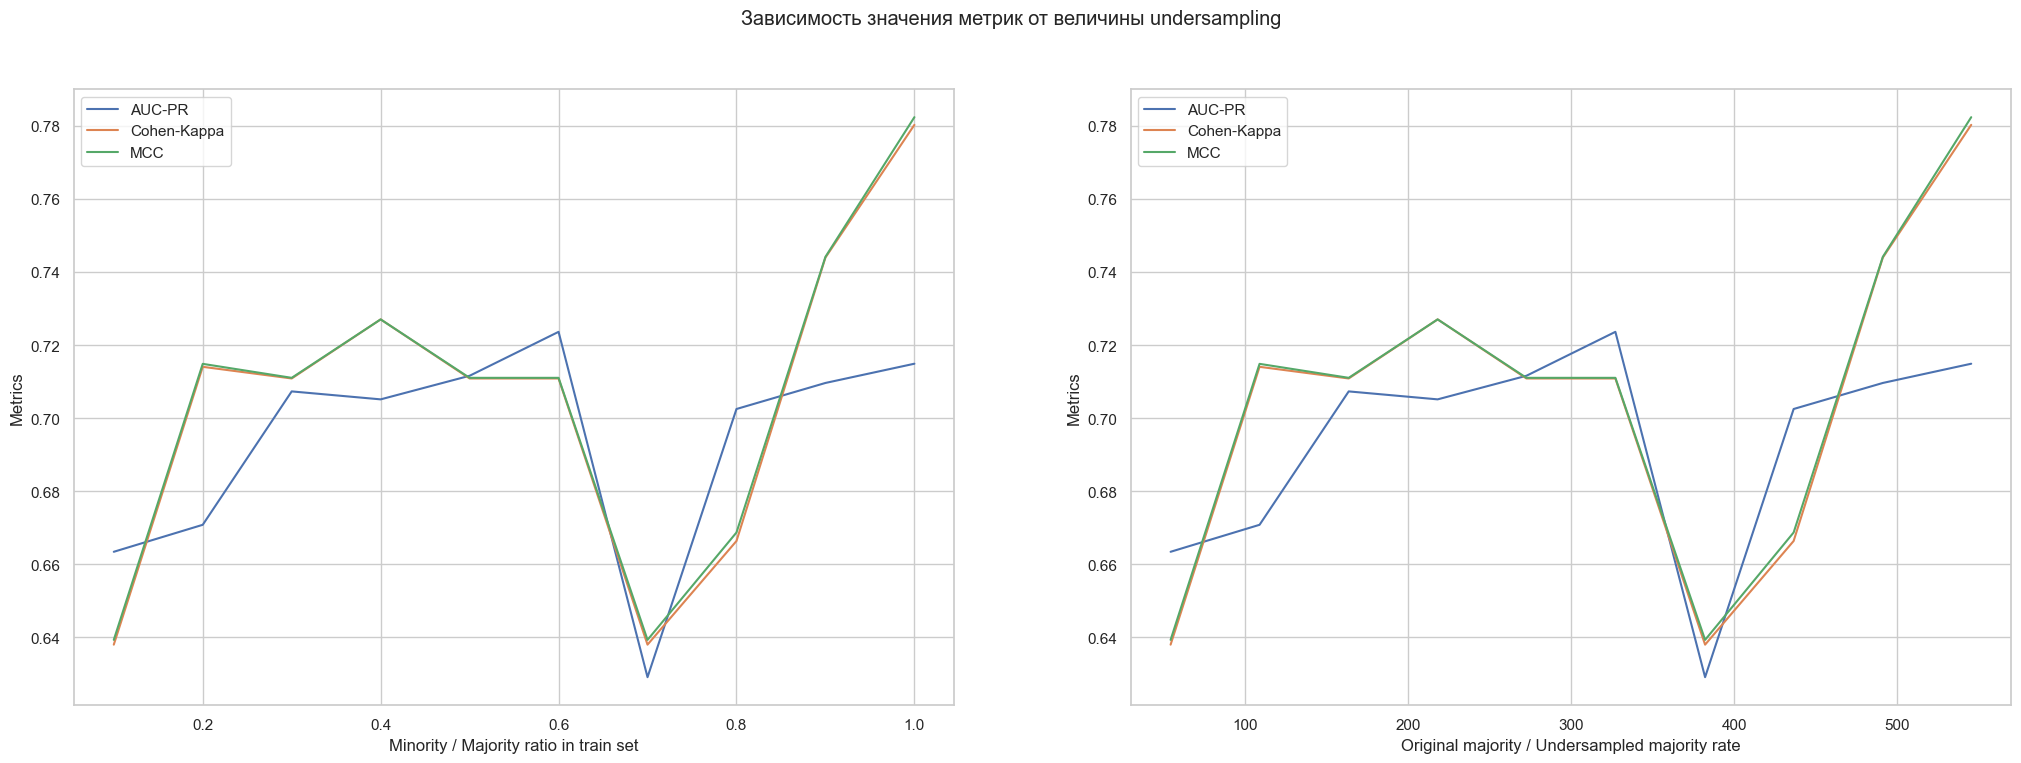

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(params_df, x="ratio", y="auc_pr", label='AUC-PR', ax=ax[0])
sns.lineplot(params_df, x="ratio", y="cohen_kappa", label='Cohen-Kappa', ax=ax[0])
sns.lineplot(params_df, x="ratio", y="mcc", label='MCC', ax=ax[0])

ax[0].set_ylabel('Metrics')
ax[0].set_xlabel('Minority / Majority ratio in train set')

sns.lineplot(params_df, x="squeeze_rate", y="auc_pr", label='AUC-PR', ax=ax[1])
sns.lineplot(params_df, x="squeeze_rate", y="cohen_kappa", label='Cohen-Kappa', ax=ax[1])
sns.lineplot(params_df, x="squeeze_rate", y="mcc", label='MCC', ax=ax[1]) 

ax[1].set_ylabel('Metrics')
ax[1].set_xlabel('Original majority / Undersampled majority rate')

plt.suptitle("Зависимость значения метрик от величины undersampling")
plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [76]:
from imblearn.under_sampling import NearMiss

optuna.logging.set_verbosity(optuna.logging.WARNING)

params_df = pd.DataFrame(columns=["ratio", "accuracy", "auc_pr", "cohen_kappa", "mcc",
                                  "threshold", "n_estimators", "l2_leaf_reg", "max_depth"])

# Перебираем от 1:10 до 1:1
for ratio in tqdm(np.arange(0.1, 1.1, 0.1)):

    X_resampled, y_resampled = NearMiss(sampling_strategy=ratio).fit_resample(X_train, y_train)
    squeeze_rate = (y_train == 0).sum() / (y_resampled == 0).sum()
    
    def objective_catboost(trial): 
        # Boosting hyperparameters
        n_estimators =  trial.suggest_int('n_estimators', 30, 60, step=5)
        l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

        # DecisionTree hyperparameters
        max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

        classifier_obj = CatBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            l2_leaf_reg=l2_leaf_reg,
            verbose=False
        )

        classifier_obj.fit(X_resampled, y_resampled)
        y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba)
        return metrics['auc_pr']

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_catboost, n_trials=12)

    # Да простит меня ассистент за постоянную копипасту поиска оптимального порога
    clf = CatBoostClassifier(**study.best_params, verbose=False)
    clf.fit(X_resampled, y_resampled)

    def objective_threshold(trial): 
        threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
        return metrics['mcc']

    study_threshold = optuna.create_study(direction='maximize')
    study_threshold.optimize(objective_threshold, n_trials=20)

    y_test_proba = clf.predict_proba(X_test)[:, 1]
    final_metrcis = calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

    params = {"ratio" : ratio, "squeeze_rate": squeeze_rate} | final_metrcis | study_threshold.best_params | study.best_params
    params = pd.DataFrame.from_dict(params, orient='index').T
    params_df = pd.concat((params_df, params), ignore_index=True)

params_df

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/pb/b204xgmn6mq45r8smpqfg__8sdc80l/T/ipykernel_1144/3587943161.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_df = pd.concat((params_df, params), ignore_index=True)


,ratio,accuracy,auc_pr,cohen_kappa,mcc,threshold,n_estimators,l2_leaf_reg,max_depth,squeeze_rate
0,0.1,0.999473,0.665609,0.633884,0.635590,0.65,30.0,11.0,8.0,54.539089
1,0.2,0.999544,0.684460,0.666442,0.671995,0.65,35.0,29.0,10.0,109.078177
2,0.3,0.999473,0.680729,0.666403,0.666568,0.70,45.0,13.0,8.0,163.735061
3,0.4,0.999508,0.668367,0.666421,0.667179,0.75,45.0,3.0,10.0,218.261036
4,0.5,0.999438,0.666740,0.651893,0.652511,0.75,35.0,3.0,8.0,272.695444
5,0.6,0.999368,0.659423,0.624686,0.626870,0.65,40.0,15.0,8.0,327.234532
6,0.7,0.999508,0.710929,0.681572,0.681572,0.70,55.0,7.0,10.0,382.231933
7,0.8,0.999579,0.667544,0.699791,0.703322,0.75,50.0,19.0,8.0,436.522073
8,0.9,0.999614,0.693396,0.731515,0.733484,0.70,30.0,25.0,8.0,491.205184
9,1.0,0.999544,0.680156,0.697446,0.697635,0.65,30.0,15.0,10.0,545.390887


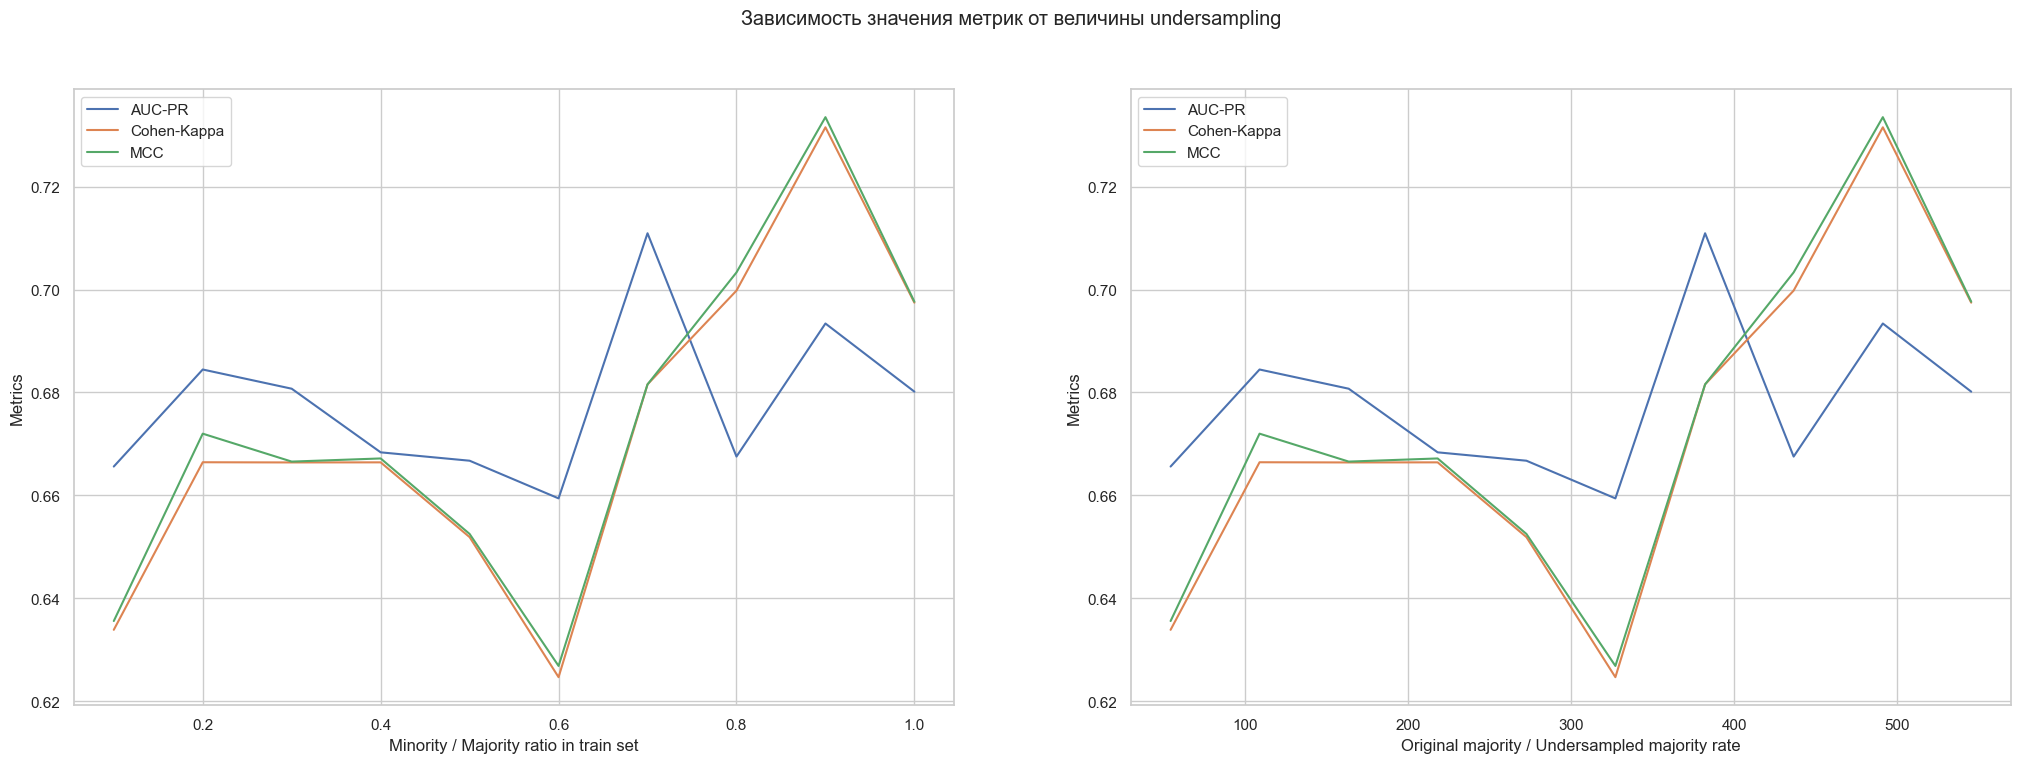

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(params_df, x="ratio", y="auc_pr", label='AUC-PR', ax=ax[0])
sns.lineplot(params_df, x="ratio", y="cohen_kappa", label='Cohen-Kappa', ax=ax[0])
sns.lineplot(params_df, x="ratio", y="mcc", label='MCC', ax=ax[0])

ax[0].set_ylabel('Metrics')
ax[0].set_xlabel('Minority / Majority ratio in train set')

sns.lineplot(params_df, x="squeeze_rate", y="auc_pr", label='AUC-PR', ax=ax[1])
sns.lineplot(params_df, x="squeeze_rate", y="cohen_kappa", label='Cohen-Kappa', ax=ax[1])
sns.lineplot(params_df, x="squeeze_rate", y="mcc", label='MCC', ax=ax[1]) 

ax[1].set_ylabel('Metrics')
ax[1].set_xlabel('Original majority / Undersampled majority rate')

plt.suptitle("Зависимость значения метрик от величины undersampling")
plt.show()

Тут очень хороший AUC-PR получаются при отношении 7:10 - переберем количество соседей для этого параметра

In [90]:
from imblearn.under_sampling import NearMiss

optuna.logging.set_verbosity(optuna.logging.WARNING)

params_df = pd.DataFrame(columns=["n_neighbors", "accuracy", "auc_pr", "cohen_kappa", "mcc",
                                  "threshold", "n_estimators", "l2_leaf_reg", "max_depth"])

# Перебираем от 3 до 10
for n_neighbors in tqdm(range(3, 11, 1)):

    X_resampled, y_resampled = NearMiss(sampling_strategy=0.7, n_neighbors=n_neighbors).fit_resample(X_train, y_train)
    
    def objective_catboost(trial): 
        # Boosting hyperparameters
        n_estimators =  trial.suggest_int('n_estimators', 30, 60, step=5)
        l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

        # DecisionTree hyperparameters
        max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

        classifier_obj = CatBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            l2_leaf_reg=l2_leaf_reg,
            verbose=False
        )

        classifier_obj.fit(X_resampled, y_resampled)
        y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba)
        return metrics['auc_pr']

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_catboost, n_trials=12)

    # Да простит меня ассистент за постоянную копипасту поиска оптимального порога
    clf = CatBoostClassifier(**study.best_params, verbose=False)
    clf.fit(X_resampled, y_resampled)

    def objective_threshold(trial): 
        threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
        return metrics['mcc']

    study_threshold = optuna.create_study(direction='maximize')
    study_threshold.optimize(objective_threshold, n_trials=20)

    y_test_proba = clf.predict_proba(X_test)[:, 1]
    final_metrcis = calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

    params = {"n_neighbors" : n_neighbors} | final_metrcis | study_threshold.best_params | study.best_params
    params = pd.DataFrame.from_dict(params, orient='index').T
    params_df = pd.concat((params_df, params), ignore_index=True)

params_df

  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/pb/b204xgmn6mq45r8smpqfg__8sdc80l/T/ipykernel_1144/1223476448.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_df = pd.concat((params_df, params), ignore_index=True)


,n_neighbors,accuracy,auc_pr,cohen_kappa,mcc,threshold,n_estimators,l2_leaf_reg,max_depth
0,3.0,0.999579,0.669099,0.714075,0.714888,0.65,30.0,23.0,8.0
1,4.0,0.999508,0.603831,0.649757,0.653034,0.80,60.0,15.0,8.0
2,5.0,0.999579,0.701605,0.727062,0.727062,0.75,60.0,21.0,10.0
3,6.0,0.999719,0.709759,0.799861,0.803896,0.65,30.0,29.0,10.0
4,7.0,0.999473,0.668289,0.650899,0.651076,0.75,45.0,23.0,8.0
5,8.0,0.972578,0.657599,0.037914,0.118357,0.90,60.0,15.0,4.0
6,9.0,0.999544,0.675277,0.580457,0.639456,0.90,40.0,9.0,6.0
7,10.0,0.999544,0.618456,0.580457,0.639456,0.90,40.0,11.0,6.0


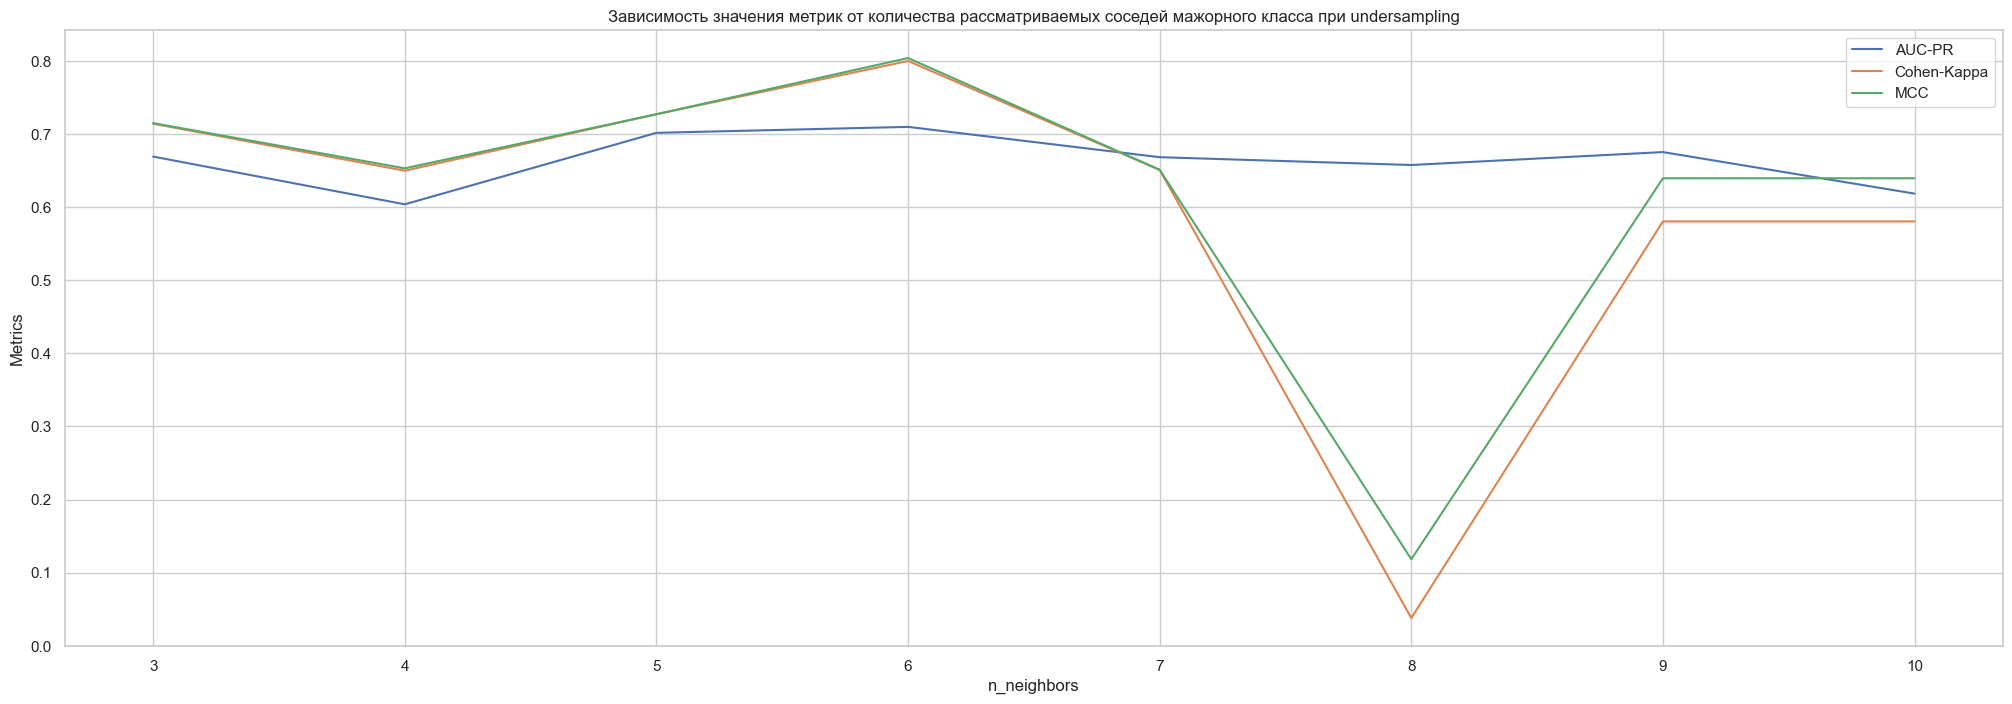

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))

sns.lineplot(params_df, x="n_neighbors", y="auc_pr", label='AUC-PR', ax=ax)
sns.lineplot(params_df, x="n_neighbors", y="cohen_kappa", label='Cohen-Kappa', ax=ax)
sns.lineplot(params_df, x="n_neighbors", y="mcc", label='MCC', ax=ax)

ax.set_ylabel('Metrics')
ax.set_xlabel('n_neighbors')

plt.title("Зависимость значения метрик от количества рассматриваемых соседей мажорного класса при undersampling")
plt.show()

**Итог:** Undersampling в целом неплохо улучшает метрики и очень сильно облегчая обучение (в отличие от oversampling, который чуть не похоронил рабочий ноут). SMOTE побить не удалось (довольно очевидно, что сжатие датасета снизило метрики), однако лучшее качество получилось на Near Miss с соотношение 7:10 и 6ю соседями (в скобках лучшие метрики на SMOTE 1:1):

**Accuracy** 0.9997 (0.9998) \
**AUC-PR** 0.710 (0.726) \
**Cohen-Kappa** 0.800 (0.820) \
**MCC** 0.804 (0.827)

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Я выбрал One-Sided Selection. Метод состоит из последовательного применения двух других методов андерсэмплинга: Condensed Nearest Neighbor и Tomek Links. 

В Condensed Nearest Neighbor сначала выбираются все объекты миноритарного класса и 1 объект мажоритарного. Затем все остальные точки классифицируются по правилу 1 ближайшего соседа, а миссклассификации добавляются в рассамтриваемое множество. Таким образом обучающая выборка строится из сложных граничных примеров.

Tomek Links строит связи Томека между ближайшими парами объектов разных классов и удаляет объекты мажорного класса, попавшие в них, - таким образом хорошо вычищается шум из мажоритарного класса.

Последовательное применение этих техник строит обучающую выборку из граничных, но не шумовых примеров.

В этом подходе нельзя задавать итоговое соотношение классов

In [92]:
from imblearn.under_sampling import OneSidedSelection

optuna.logging.set_verbosity(optuna.logging.INFO)

X_resampled, y_resampled = OneSidedSelection().fit_resample(X_train, y_train)
ratio = (y_resampled == 1).sum() / (y_resampled == 0).sum()

def objective_catboost(trial): 
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 60, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=12)

# Да простит меня ассистент за постоянную копипасту поиска оптимального порога
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective_threshold(trial): 
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective_threshold, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold']) | {"ratio" : ratio}

[I 2024-05-20 12:16:01,629] A new study created in memory with name: no-name-63edfd79-fc8f-4de4-8086-d90374d3a748
[I 2024-05-20 12:16:12,610] Trial 0 finished with value: 0.8383133733834623 and parameters: {'n_estimators': 60, 'l2_leaf_reg': 19, 'max_depth': 12}. Best is trial 0 with value: 0.8383133733834623.
[I 2024-05-20 12:16:23,076] Trial 1 finished with value: 0.8376727928759933 and parameters: {'n_estimators': 55, 'l2_leaf_reg': 9, 'max_depth': 12}. Best is trial 0 with value: 0.8383133733834623.
[I 2024-05-20 12:16:23,695] Trial 2 finished with value: 0.8246528624679332 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 13, 'max_depth': 4}. Best is trial 0 with value: 0.8383133733834623.
[I 2024-05-20 12:16:26,536] Trial 3 finished with value: 0.8303039650599284 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 7, 'max_depth': 10}. Best is trial 0 with value: 0.8383133733834623.
[I 2024-05-20 12:16:29,692] Trial 4 finished with value: 0.8513344516247965 and parameters: {'n_e

{'accuracy': 0.9994382219725431,
 'auc_pr': 0.6952800118086081,
 'cohen_kappa': 0.6663874946557107,
 'mcc': 0.6687173797351023,
 'ratio': 0.001837328163553049}

А разговоров то было... На мой взгляд, undersampling нужно очень тщательно подбирать, а еще иметь хоть сколько-то значимую выборку миноритарного класса. Этот метод в принципе не справился с задачей андерсемплинга, почти не поменяв соотношение(((

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

def objective(trial):
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-20 20:27:13,598] A new study created in memory with name: no-name-245b9fab-4350-4e9d-943b-f3d59ec56882
[I 2024-05-20 20:27:21,759] Trial 0 finished with value: 0.8018968805794594 and parameters: {'n_estimators': 35, 'l2_leaf_reg': 27, 'max_depth': 6}. Best is trial 0 with value: 0.8018968805794594.
[I 2024-05-20 20:28:08,399] Trial 1 finished with value: 0.8381931537885096 and parameters: {'n_estimators': 45, 'l2_leaf_reg': 13, 'max_depth': 12}. Best is trial 1 with value: 0.8381931537885096.
[I 2024-05-20 20:28:24,807] Trial 2 finished with value: 0.8195532935105969 and parameters: {'n_estimators': 30, 'l2_leaf_reg': 3, 'max_depth': 10}. Best is trial 1 with value: 0.8381931537885096.
[I 2024-05-20 20:28:35,694] Trial 3 finished with value: 0.8188941513187977 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 17, 'max_depth': 8}. Best is trial 1 with value: 0.8381931537885096.
[I 2024-05-20 20:28:49,503] Trial 4 finished with value: 0.8295197277829315 and parameters: {'n_e

In [ ]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9971208876092834,
 'auc_pr': 0.7224244053011712,
 'cohen_kappa': 0.292217379972482,
 'mcc': 0.37299276261596215}

In [ ]:
def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.01)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=40)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-20 20:44:25,031] A new study created in memory with name: no-name-20036280-1e4b-4b94-9bd1-331d9450eea9
[I 2024-05-20 20:44:25,101] Trial 0 finished with value: 0.8034042085901285 and parameters: {'threshold': 0.8200000000000001}. Best is trial 0 with value: 0.8034042085901285.
[I 2024-05-20 20:44:25,154] Trial 1 finished with value: 0.2536318133291832 and parameters: {'threshold': 0.15}. Best is trial 0 with value: 0.8034042085901285.
[I 2024-05-20 20:44:25,204] Trial 2 finished with value: 0.5585148080907889 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 0.8034042085901285.
[I 2024-05-20 20:44:25,252] Trial 3 finished with value: 0.4406832592320868 and parameters: {'threshold': 0.33}. Best is trial 0 with value: 0.8034042085901285.
[I 2024-05-20 20:44:25,317] Trial 4 finished with value: 0.27202369160648326 and parameters: {'threshold': 0.16}. Best is trial 0 with value: 0.8034042085901285.
[I 2024-05-20 20:44:25,367] Trial 5 finished with value: 0.34428852

{'accuracy': 0.9997542221129876,
 'auc_pr': 0.7224244053011712,
 'cohen_kappa': 0.8203918699904775,
 'mcc': 0.8272276657666917}

In [ ]:
y_test_proba = clf.predict_proba(X_test)[:, 1] > study_threshold.best_params['threshold']
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9997542221129876,
 'auc_pr': 0.8343299323106295,
 'cohen_kappa': 0.8203918699904775,
 'mcc': 0.8272276657666917}

Я все еще не понимаю, как выбить auc_pr > 0.8 на вероятностях, но на бинарных метках вот все славно. В качестве метода был просто такой же SMOTE 1:1, как выше. Порог при этом 0.96 - очень интересно

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [9]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    # Мы работяги, делаем базу
    return np.log2(n)

def calc_height(X, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: np.array - anomaly scores for sample
    """
    if node.kind == "external":
        return node.depth + c_factor(node.size)
    
    if len(X) == 0:
        return 0
    
    scores = np.zeros(X.shape[0])
    split = node.split_sample(X)

    scores[split == -1] = calc_height(X[split == -1], node.left)
    scores[split == 1] = calc_height(X[split == 1], node.right)

    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"
    
    # Добавил вот это
    def split_sample(self, X):
        """
        Splits samples in current node to children
        Params:
            X: np.array - current sample, available to node
        Returns:
            mask: np.array - anomaly scores for sample
        """
        return np.sign(X @ self.w + self.b)


class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        self.depth = max(self.depth, depth)

        if depth > self.max_depth:
            raise Exception("Depth of a single tree is more than max_depth")
        elif depth == self.max_depth or len(X) == 1:
            self.external_count += 1
            return Node(X, depth, None, None, "external", None, None)

        left, right = None, None

        while left is None or right is None:
            w = np.random.randn(X.shape[1])
            b = np.random.uniform(low=X.min(), high=X.max())

            split = np.sign(X @ w + b)

            if (split == 1).sum() > 0 and (split == -1).sum() > 0:
                left = self.grow(X[split == -1], depth + 1)
                right = self.grow(X[split == 1], depth + 1)
        
        self.internal_count += 1
        return Node(X, depth, left, right, "internal", w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """

        return calc_height(X, self.root)
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        # Вероятность попадания в конкретную точку d-мерного пространства конечно же равна нулю, но мы не знаем природу данных (может там все фичи бинарные)
        # Поэтому почистим датасет от повторений, чтобы в любой вершине с > 1 объектом можно было гарантировать существование разбивающей гиперплоскости

        X_unique = np.unique(X, axis=0)
        self.subsample_size = int(X_unique.shape[0] * self.subsample_rate)

        for _ in range(self.n_trees):
            X_subsample = X_unique[np.random.choice(X_unique.shape[0],  self.subsample_size, replace=False), :]

            max_depth = self.max_depth
            if not self.max_depth:
                max_depth = np.ceil(np.log2(self.subsample_size))
            new_tree = RandomizedTree(X_subsample, max_depth)
            self.trees.append(new_tree)

        self.is_fit = True
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: (samples x dim) np.array - new samples

        Returns:
            scores: np.array (samples) - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        scores = np.zeros(X.shape[0])
        for tree in self.trees:
            scores += tree.score_samples(X)
        return np.exp2(-scores / self.n_trees / c_factor(self.subsample_size))
    
    def predict_proba(self, X):
        pass
    predict_proba = score_samples
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        # score -> 1 соответствует аномалии
        labels = scores > (1 - self.contamination)
        return labels


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

Отскейлим наши данные

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [191]:
eif = ExtendedIsolationForest(50, subsample_rate=0.8, max_depth=5, contamination=0.02)
eif.fit(X_train_scaled)

ExtendedIsolationForest(n_trees=50, max_depth=5, subsample_rate=0.8, contamination=0.02, is_fit=True)

In [192]:
y_pred = eif.predict_proba(X_train_scaled)
calc_metrics(y_train, y_pred)

{'accuracy': 0.9965853979679168,
 'auc_pr': 0.19166530765562037,
 'cohen_kappa': 0.28462175242038246,
 'mcc': 0.292850881225973}

Метрики очень плохие, но подсказка про подвыборку фичей нам в помощь

In [11]:
valuable_params = np.abs(df.drop(columns=['Class']).corrwith(df.Class)).sort_values().keys()[-5:]
valuable_params

Index(['V16', 'V10', 'V12', 'V14', 'V17'], dtype='object')

In [12]:
scaler = StandardScaler().fit(X_train[valuable_params])
X_train_scaled = scaler.transform(X_train[valuable_params])
X_val_scaled = scaler.transform(X_val[valuable_params])
X_test_scaled = scaler.transform(X_test[valuable_params])

In [205]:
eif = ExtendedIsolationForest(50, subsample_rate=0.8, max_depth=5)
eif.fit(X_train_scaled)
y_pred = eif.predict_proba(X_train_scaled)
calc_metrics(y_train, y_pred)

{'accuracy': 0.9970462375737892,
 'auc_pr': 0.6162774254192093,
 'cohen_kappa': 0.4946080644034784,
 'mcc': 0.5338300736861809}

Так-то лучше - подберем гиперпараметры. Contamination - это по сути порог, который мы будем перебирать по mcc

In [220]:
def objective(trial):
    n_trees =  trial.suggest_int('n_trees', 10, 70, step=5)
    subsample_rate = trial.suggest_float("subsample_rate", 0.1, 1, step=0.1)
    max_depth = trial.suggest_int('max_depth', 4, 10, step=2)

    eif = ExtendedIsolationForest(
        n_trees=n_trees,
        max_depth=max_depth,
        subsample_rate=subsample_rate
    )

    eif.fit(X_train_scaled)
    y_train_proba = eif.predict_proba(X_train_scaled)
    metrics = calc_metrics(y_train, y_train_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-05-21 03:23:52,496] A new study created in memory with name: no-name-b5fdeb61-8751-4afa-a3fa-21b0a426afd7
[I 2024-05-21 03:23:54,381] Trial 0 finished with value: 0.5040080973765918 and parameters: {'n_trees': 15, 'subsample_rate': 0.9, 'max_depth': 4}. Best is trial 0 with value: 0.5040080973765918.
[I 2024-05-21 03:24:04,868] Trial 1 finished with value: 0.6008297319870514 and parameters: {'n_trees': 55, 'subsample_rate': 0.6, 'max_depth': 8}. Best is trial 1 with value: 0.6008297319870514.
[I 2024-05-21 03:24:08,285] Trial 2 finished with value: 0.5863215643489077 and parameters: {'n_trees': 25, 'subsample_rate': 0.1, 'max_depth': 8}. Best is trial 1 with value: 0.6008297319870514.
[I 2024-05-21 03:24:10,799] Trial 3 finished with value: 0.6145481824390607 and parameters: {'n_trees': 30, 'subsample_rate': 0.5, 'max_depth': 4}. Best is trial 3 with value: 0.6145481824390607.
[I 2024-05-21 03:24:16,599] Trial 4 finished with value: 0.6081883257483045 and parameters: {'n_trees'

In [226]:
eif = ExtendedIsolationForest(**study.best_params)
eif.fit(X_train_scaled)
y_train_proba = eif.predict_proba(X_train_scaled)
calc_metrics(y_train, y_train_proba)

{'accuracy': 0.9963835063310584,
 'auc_pr': 0.6106417691291145,
 'cohen_kappa': 0.46210729706873155,
 'mcc': 0.5199100259728577}

Без фиксирования random_state при обучении метрики, конечно, пляшут

In [227]:
def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.01)

    y_train_proba = eif.predict_proba(X_train_scaled)
    metrics = calc_metrics(y_train, y_train_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=10)

y_test_proba = eif.predict_proba(X_test_scaled)
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-21 03:26:59,826] A new study created in memory with name: no-name-583377c0-bb9e-4f26-91cf-c68bff96bbbd
[I 2024-05-21 03:27:01,485] Trial 0 finished with value: 0.630032096118329 and parameters: {'threshold': 0.58}. Best is trial 0 with value: 0.630032096118329.
[I 2024-05-21 03:27:03,397] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.33}. Best is trial 0 with value: 0.630032096118329.
[I 2024-05-21 03:27:05,018] Trial 2 finished with value: 0.0488360994161455 and parameters: {'threshold': 0.75}. Best is trial 0 with value: 0.630032096118329.
[I 2024-05-21 03:27:06,752] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.3}. Best is trial 0 with value: 0.630032096118329.
[I 2024-05-21 03:27:08,360] Trial 4 finished with value: 0.2640320290672369 and parameters: {'threshold': 0.45}. Best is trial 0 with value: 0.630032096118329.
[I 2024-05-21 03:27:10,061] Trial 5 finished with value: 0.13271311608942682 and parameters: {'threshold': 0.68}. Best

{'accuracy': 0.9991924440855307,
 'auc_pr': 0.2825004828663457,
 'cohen_kappa': 0.3026712043679456,
 'mcc': 0.32105197450212125}

In [228]:
y_val_proba = eif.predict_proba(X_val_scaled)
calc_metrics(y_val, y_val_proba, threshold=study_threshold.best_params['threshold'])

{'accuracy': 0.9989115550718023,
 'auc_pr': 0.7358296148900562,
 'cohen_kappa': 0.6167909364307964,
 'mcc': 0.6485373715435997}

На валидации скор очень хороший, auc_pr лучше supervised методово, однако так просто сложились звезды...

In [230]:
study.best_params

{'n_trees': 15, 'subsample_rate': 0.6, 'max_depth': 8}

In [234]:
from sklearn.ensemble import IsolationForest

if_sklearn = IsolationForest(n_estimators=study.best_params['n_trees'], max_samples=study.best_params['subsample_rate'], contamination=y_train.mean()).fit(X_train_scaled)
y_train_proba = if_sklearn.score_samples(X_train_scaled)
calc_metrics(y_train, y_train_proba)

{'accuracy': 0.9981698084223924,
 'auc_pr': 0.0009211676791622072,
 'cohen_kappa': 0.0,
 'mcc': 0.0}

In [235]:
y_train_proba = if_sklearn.predict(X_train_scaled)
calc_metrics(y_train, y_train_proba)

{'accuracy': 0.0014571309442822972,
 'auc_pr': 0.19995653110452954,
 'cohen_kappa': -0.0022046079491975235,
 'mcc': -0.6011885638964074}

In [236]:
y_test_proba = if_sklearn.predict(X_test_scaled)
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.0012288894350619712,
 'auc_pr': 0.36402283280509773,
 'cohen_kappa': -0.00042067108086629723,
 'mcc': -0.255228022641472}

Уф, auc-pr еще куда не шло, а вот согласованность хуже рандома. Наш метод супер хорош!

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

Text(0.5, 0, 'Anomaly score')

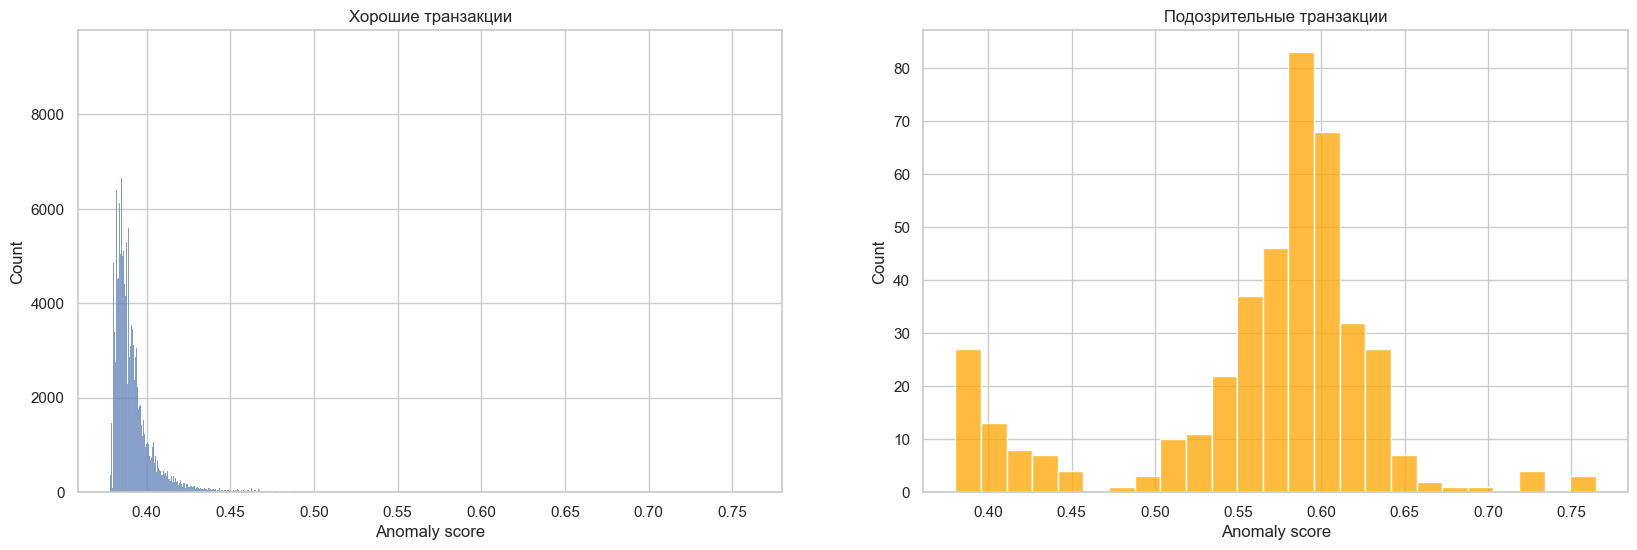

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(eif.predict_proba(X_train_scaled[y_train == 0]), ax=ax[0])
ax[0].set_title('Хорошие транзакции')
ax[0].set_xlabel('Anomaly score')

sns.histplot(eif.predict_proba(X_train_scaled[y_train == 1]), color='orange', ax=ax[1])
ax[1].set_title('Подозрительные транзакции')
ax[1].set_xlabel('Anomaly score')

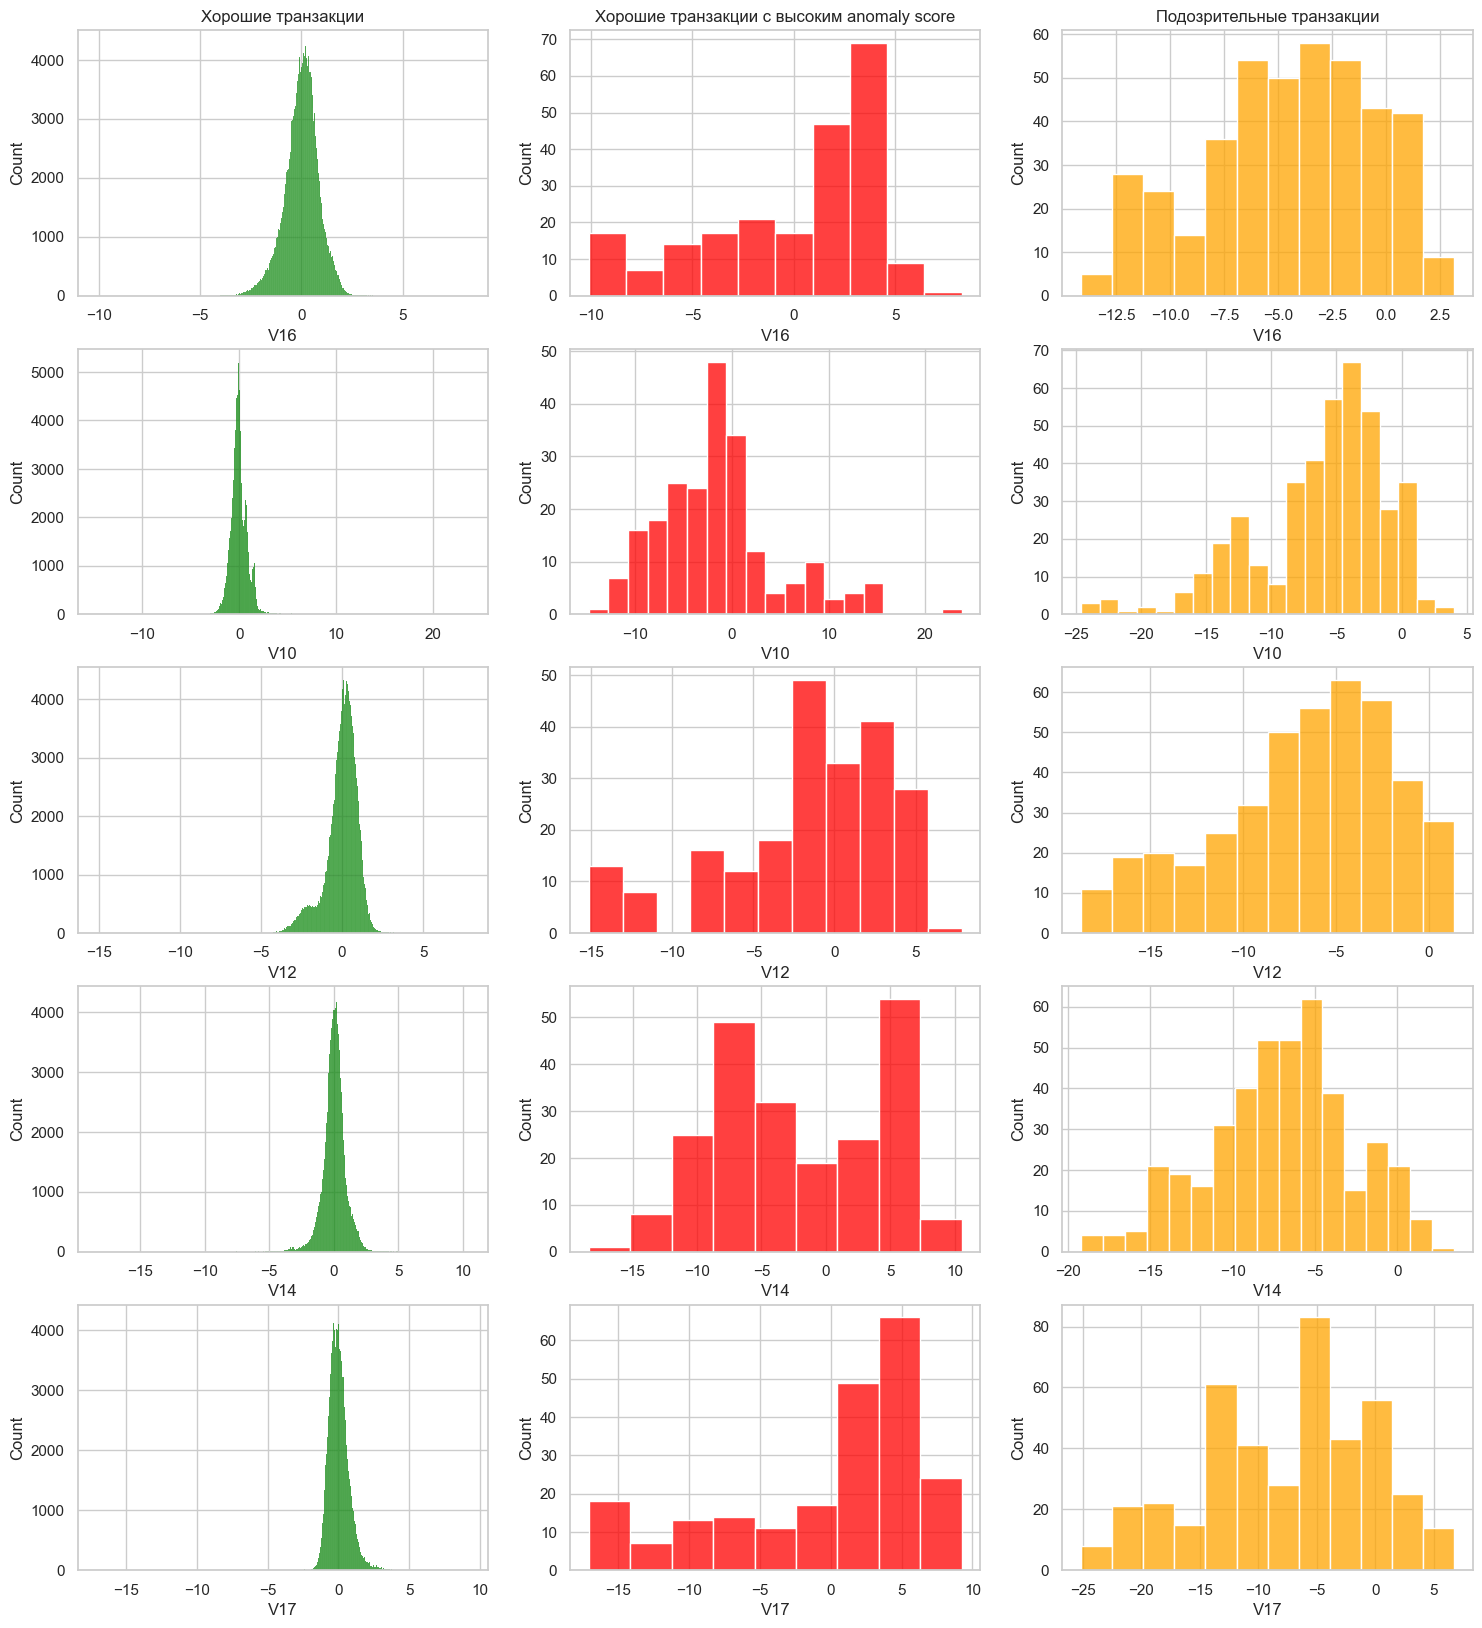

In [257]:
valuable_params = np.abs(df.drop(columns=['Class']).corrwith(df.Class)).sort_values().keys()[-5:]

fig, ax = plt.subplots(5, 3, figsize=(18, 20))

ax[0][0].set_title('Хорошие транзакции')
ax[0][1].set_title('Хорошие транзакции с высоким anomaly score')
ax[0][2].set_title('Подозрительные транзакции')

anomaly_score_samples = X_train[y_train == 0][eif.predict_proba(X_train_scaled[y_train == 0]) > 0.55]

for i, param in enumerate(valuable_params):
    sns.histplot(X_train[y_train == 0], x=param, ax=ax[i][0], color='green')
    sns.histplot(anomaly_score_samples, x=param, ax=ax[i][1], color='red')
    sns.histplot(X_train[y_train == 1], x=param, ax=ax[i][2], color='orange')
    
plt.show()

Можно заметить, что негативные объекты с большим скором (> 0.55, где начинается высокая плотность целевых объектов) по рассматриваемым параметрам имеют распределение, смещенное от нормы в сторону подозрительных транзакций. Либо это шумовые точки, либо такие объекты, у которых сразу несколько параметров схожи по значению с подозрительными. По такой системе можно получить блокировку счетов в банке, будучи false positive примером.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [14]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(novelty=True).fit(X_train_scaled)

y_test_proba = lof.predict(X_test_scaled)
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.034479126435167304,
 'auc_pr': 0.4549439773812958,
 'cohen_kappa': -9.131080059820995e-05,
 'mcc': -0.008773329060274497}

In [16]:
from sklearn.svm import OneClassSVM

osvm = OneClassSVM(kernel='linear').fit(X_train_scaled)

y_test_proba = osvm.predict(X_test_scaled)
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9589199817422142,
 'auc_pr': 0.13923073227391652,
 'cohen_kappa': 0.008649262430317606,
 'mcc': 0.032633555349050165}

Мдаааа....

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [26]:
eif = ExtendedIsolationForest(n_trees=15, subsample_rate=0.6, max_depth=8)
eif.fit(X_train_scaled)

y_train_proba = eif.predict_proba(X_train_scaled)
calc_metrics(y_train, y_train_proba)

{'accuracy': 0.9954398823761768,
 'auc_pr': 0.5728718066825741,
 'cohen_kappa': 0.3903550954654925,
 'mcc': 0.4548851924417228}

In [32]:
for dataset, dataset_scaled in zip([X_train, X_val, X_test], [X_train_scaled, X_val_scaled, X_test_scaled]):
    dataset['eif'] = eif.score_samples(dataset_scaled)
    dataset['lof'] = lof.score_samples(dataset_scaled)
    dataset['osvm'] = osvm.score_samples(dataset_scaled)

In [36]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

clf = CatBoostClassifier(n_estimators=50, l2_leaf_reg=21, max_depth=12, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9961377760612338,
 'auc_pr': 0.7271218241468218,
 'cohen_kappa': 0.23510997349542073,
 'mcc': 0.32714738094247825}

In [37]:
def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.01)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=40)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-21 04:56:11,062] A new study created in memory with name: no-name-e60c3bde-4151-4943-849f-a242f5e25c50
[I 2024-05-21 04:56:11,100] Trial 0 finished with value: 0.850358109092135 and parameters: {'threshold': 0.91}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-21 04:56:11,134] Trial 1 finished with value: 0.3128843926540246 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-21 04:56:11,165] Trial 2 finished with value: 0.14029131755791038 and parameters: {'threshold': 0.08}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-21 04:56:11,197] Trial 3 finished with value: 0.4605068619492882 and parameters: {'threshold': 0.35000000000000003}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-21 04:56:11,231] Trial 4 finished with value: 0.7156813040256172 and parameters: {'threshold': 0.78}. Best is trial 0 with value: 0.850358109092135.
[I 2024-05-21 04:56:11,263] Trial 5 finished with value: 0.3802025041252

{'accuracy': 0.9995435553526912,
 'auc_pr': 0.7271218241468218,
 'cohen_kappa': 0.7108828212298137,
 'mcc': 0.7110586906187203}

Нуууу, стало хуже...

In [38]:
for dataset, dataset_scaled in zip([X_train, X_val, X_test], [X_train_scaled, X_val_scaled, X_test_scaled]):
    dataset['eif_is_outlier'] = eif.predict(dataset_scaled)
    dataset['lof_is_outlier'] = lof.predict(dataset_scaled)
    dataset['osvm_is_outlier'] = osvm.predict(dataset_scaled)

In [39]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

clf = CatBoostClassifier(n_estimators=50, l2_leaf_reg=21, max_depth=12, verbose=False)
clf.fit(X_resampled, y_resampled)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba)

{'accuracy': 0.9971208876092834,
 'auc_pr': 0.7092466488819006,
 'cohen_kappa': 0.27980384767912525,
 'mcc': 0.3547740589363482}

In [40]:
def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.01)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=40)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-21 05:08:22,567] A new study created in memory with name: no-name-60797005-666f-46f9-a68f-a716d0630e1c
[I 2024-05-21 05:08:22,617] Trial 0 finished with value: 0.6926190681743581 and parameters: {'threshold': 0.54}. Best is trial 0 with value: 0.6926190681743581.
[I 2024-05-21 05:08:22,662] Trial 1 finished with value: 0.6926190681743581 and parameters: {'threshold': 0.54}. Best is trial 0 with value: 0.6926190681743581.
[I 2024-05-21 05:08:22,706] Trial 2 finished with value: 0.524938841327528 and parameters: {'threshold': 0.36}. Best is trial 0 with value: 0.6926190681743581.
[I 2024-05-21 05:08:22,747] Trial 3 finished with value: 0.4611918196129221 and parameters: {'threshold': 0.27}. Best is trial 0 with value: 0.6926190681743581.
[I 2024-05-21 05:08:22,789] Trial 4 finished with value: 0.850358109092135 and parameters: {'threshold': 0.89}. Best is trial 4 with value: 0.850358109092135.
[I 2024-05-21 05:08:22,827] Trial 5 finished with value: 0.7920658877375747 and para

{'accuracy': 0.9995084442259752,
 'auc_pr': 0.7092466488819006,
 'cohen_kappa': 0.6954066627453077,
 'mcc': 0.6960659441542087}

Эхэхэх, мне кажется, ожидались более высокие метрики

/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


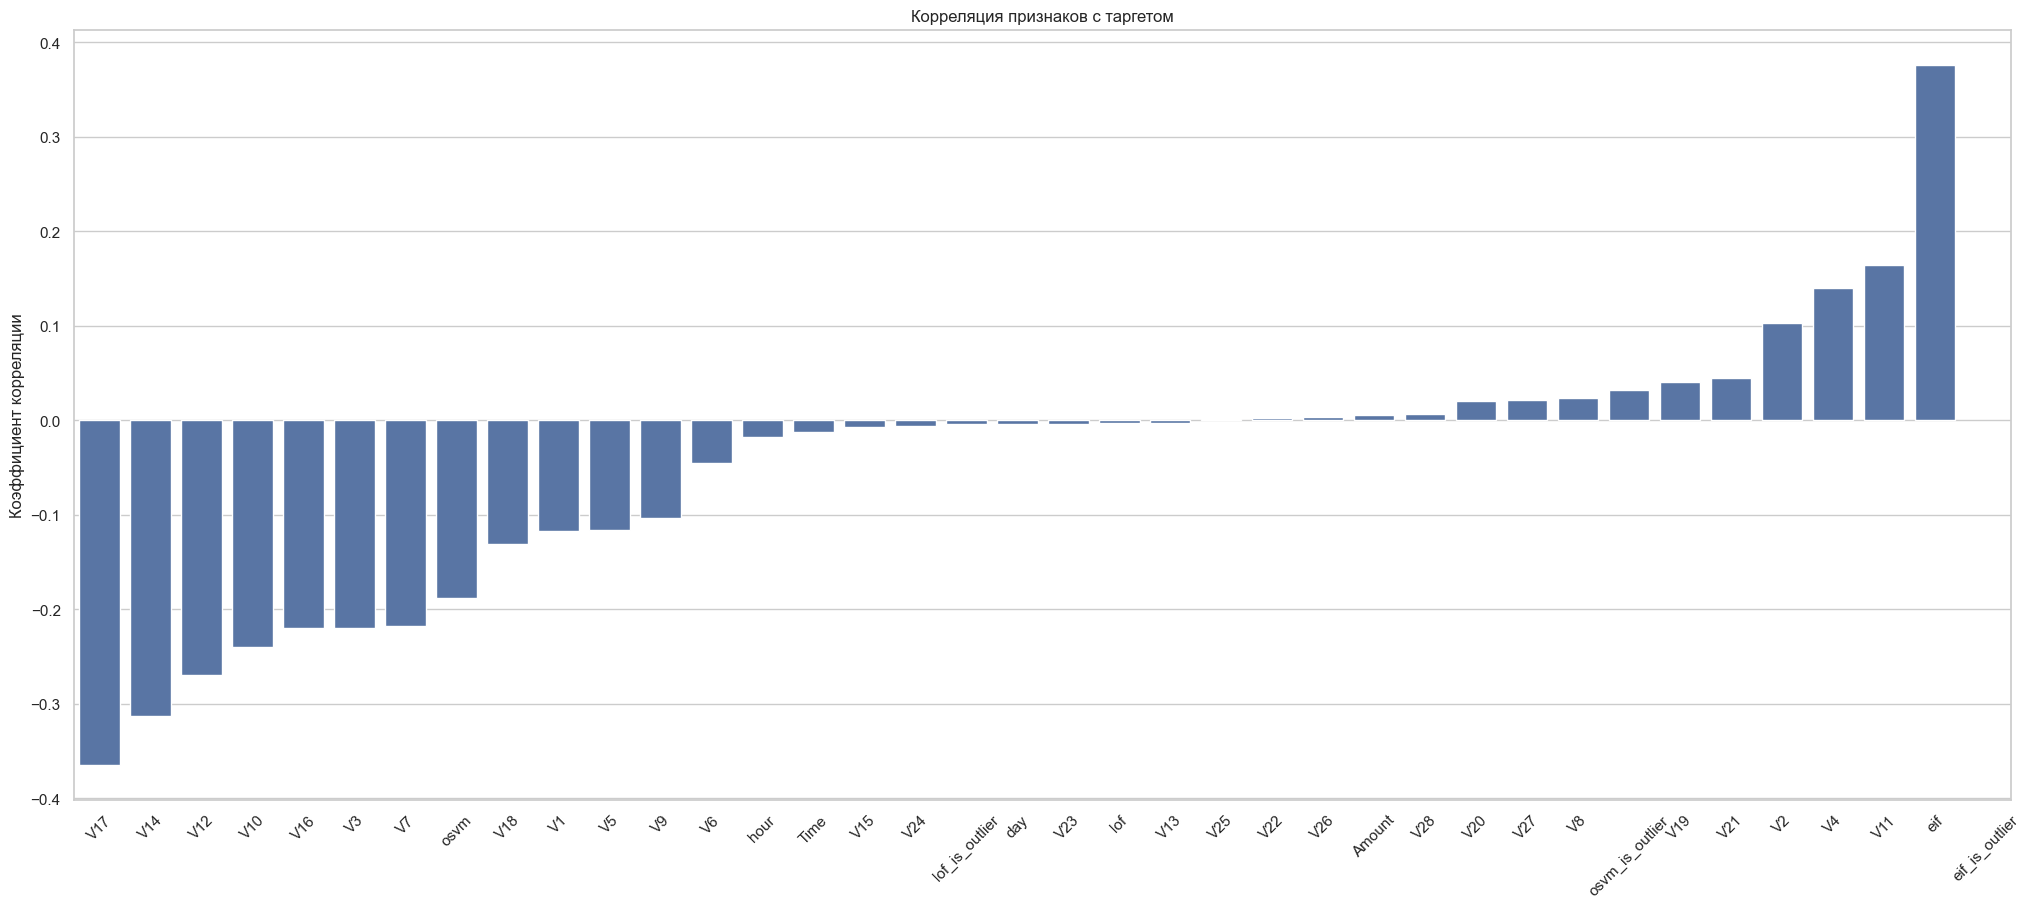

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

sns.barplot(X_train.corrwith(y_train).sort_values(), ax=ax)
ax.set_title('Корреляция признаков с таргетом')
ax.set_ylabel('Коэффициент корреляции')

plt.xticks(rotation=45)
plt.show()

Но eif вообще строит очень интересные метрики, давайте-ка потюним

In [44]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

def objective(trial):
    # Boosting hyperparameters
    n_estimators =  trial.suggest_int('n_estimators', 30, 55, step=5)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 29, step=2)

    # DecisionTree hyperparameters
    max_depth = trial.suggest_int('max_depth', 4, 12, step=2)

    classifier_obj = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False
    )

    classifier_obj.fit(X_resampled, y_resampled)
    y_val_proba = classifier_obj.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba)
    return metrics['auc_pr']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-05-21 05:13:15,403] A new study created in memory with name: no-name-78e8eb5f-66c1-4447-ab89-cd81560ef3c6
[I 2024-05-21 05:13:26,501] Trial 0 finished with value: 0.8405000147846722 and parameters: {'n_estimators': 40, 'l2_leaf_reg': 5, 'max_depth': 12}. Best is trial 0 with value: 0.8405000147846722.
[I 2024-05-21 05:13:42,658] Trial 1 finished with value: 0.8249044898514978 and parameters: {'n_estimators': 50, 'l2_leaf_reg': 15, 'max_depth': 12}. Best is trial 0 with value: 0.8405000147846722.
[I 2024-05-21 05:13:45,561] Trial 2 finished with value: 0.8149158520789072 and parameters: {'n_estimators': 45, 'l2_leaf_reg': 21, 'max_depth': 8}. Best is trial 0 with value: 0.8405000147846722.
[I 2024-05-21 05:13:47,675] Trial 3 finished with value: 0.797718860971978 and parameters: {'n_estimators': 45, 'l2_leaf_reg': 9, 'max_depth': 6}. Best is trial 0 with value: 0.8405000147846722.
[I 2024-05-21 05:13:49,478] Trial 4 finished with value: 0.8014412698153073 and parameters: {'n_est

In [46]:
clf = CatBoostClassifier(**study.best_params, verbose=False)
clf.fit(X_resampled, y_resampled)

def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1, step=0.05)

    y_val_proba = clf.predict_proba(X_val)[:, 1]
    metrics = calc_metrics(y_val, y_val_proba, threshold=threshold)
    return metrics['mcc']

study_threshold = optuna.create_study(direction='maximize')
study_threshold.optimize(objective, n_trials=20)

y_test_proba = clf.predict_proba(X_test)[:, 1]
calc_metrics(y_test, y_test_proba, threshold=study_threshold.best_params['threshold'])

[I 2024-05-21 05:16:46,378] A new study created in memory with name: no-name-2ac8a8b7-3ea0-4198-8b6d-a41ec5db9521
[I 2024-05-21 05:16:46,419] Trial 0 finished with value: 0.7798266329715834 and parameters: {'threshold': 0.6000000000000001}. Best is trial 0 with value: 0.7798266329715834.
[I 2024-05-21 05:16:46,459] Trial 1 finished with value: 0.17900415287454702 and parameters: {'threshold': 0.05}. Best is trial 0 with value: 0.7798266329715834.
[I 2024-05-21 05:16:46,497] Trial 2 finished with value: 0.41432993302652715 and parameters: {'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.7798266329715834.
[I 2024-05-21 05:16:46,537] Trial 3 finished with value: 0.800144787126371 and parameters: {'threshold': 0.65}. Best is trial 3 with value: 0.800144787126371.
[I 2024-05-21 05:16:46,576] Trial 4 finished with value: 0.17900415287454702 and parameters: {'threshold': 0.05}. Best is trial 3 with value: 0.800144787126371.
[I 2024-05-21 05:16:46,613] Trial 5 finished with va

{'accuracy': 0.9995435553526912,
 'auc_pr': 0.7125134784926357,
 'cohen_kappa': 0.7108828212298137,
 'mcc': 0.7110586906187203}

**Итог:** unsupervised методы очевидно уступают нашему затюненому катбусту. Однако их можно использовать для построения новых методов. У нас это особо не сработало, но eif показал высокую скоррелированность с таргетом. Вывод по всей работе такой: усложнение задачи в сторону несбалансированности классов усложняет и подбор модели с гиперпараметрами

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: хочу

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [33]:
# import random

# rng = random.SystemRandom(0)
# rng.uniform(-1.0, 1.0)